# Introduction

This is a dataset that we got from Kaggle at [https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic]. This dataset contains paired images of 10,000 human pics, along with their respective comic pics pairs. So, it is a total of 20,000 images in this dataset.

We are going to perform some EDA on this dataset, and then we are going to train a couple of different models on a subset of this dataset, along with some hyperparameter tuning.

### Goal

The goal of this project is to try to generate a comic version of a human image.

Ever since I worked on the CycleGAN Monet assignment, I wanted to try out something like this, as this is something that I find to be fascinating.

# Plan

1. Perform EDA
2. Train Models, with hyperparameter tuning
3. Train Final Model using the Best Parameters
4. Use the final model to generate comic images of "untrained" human images.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [3]:
def get_image_filenames(face_dir):
    return sorted(os.listdir(face_dir))

In [4]:
def get_dataset(root_dir, image_size=256):
    face_dir = os.path.join(root_dir, 'face')
    comic_dir = os.path.join(root_dir, 'comics')
    filenames = get_image_filenames(face_dir)

    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T. ToTensor(),
        T. Normalize([0.5]*3, [0.5]*3)
])
    
    def dataset_fn(index):
        fname = filenames[index]
        face_path = os.path.join(face_dir, fname)
        comic_path = os.path.join(comic_dir, fname)

        face = Image.open(face_path).convert("RGB")
        comic = Image.open(comic_path).convert("RGB")

        face = transform(face)
        comic = transform(comic)
        return {
            'face': face,
            'comic': comic,
            'filename': fname
        }

    return dataset_fn, len(filenames)

In [5]:
def get_dataloader_from_fn(dataset_fn, dataset_len, batch_size=16, shuffle=True, num_workers=2, subset_indices=None):
    class FunctionalDataset(Dataset):
        def __len__(self):
            return len(subset_indices) if subset_indices is not None else dataset_len

        def __getitem__(self, idx):
            idx = subset_indices[idx] if subset_indices is not None else idx
            return dataset_fn(idx)
    return DataLoader(FunctionalDataset(), batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [6]:
dataset_fn, dataset_len = get_dataset('/Users/cuibin/Desktop/archive/face2comics', image_size=256)

subset_indices = list(range(100))

dataloader = get_dataloader_from_fn(dataset_fn, dataset_len, batch_size=4, shuffle=True, num_workers=0, subset_indices=subset_indices)

for batch in dataloader:
    print(batch['face'].shape, batch['comic'].shape)
    break

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


In [7]:
def show_real_vs_comic(real, comic, max_images=8):
    real = real[:max_images]
    comic = comic[:max_images]

    real = (real * 0.5) + 0.5
    comic = (comic * 0.5) + 0.5

    fig, axes = plt.subplots(2, max_images, figsize=(3 * max_images, 6))

    for i in range(max_images):
        axes[0, i].imshow(real[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[0, i].set_title("Real")

        axes[1, i].imshow(comic[i].permute(1, 2, 0).cpu().numpy ())
        axes[1, i].axis('off')
        axes[1, i].set_title("Comic")
    plt. tight_layout()
    plt. show()

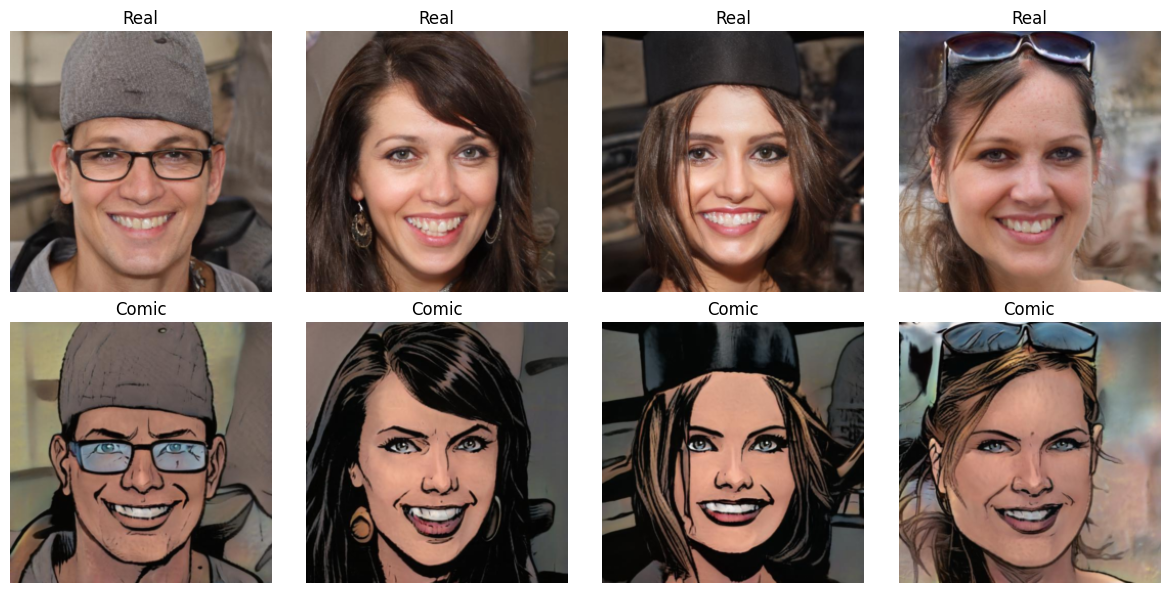

In [8]:
for batch in dataloader:
    show_real_vs_comic(batch['face'], batch['comic'], max_images=4)
    break

## Observation on this dataset

As we can see from just these 4 images, some of the "human" pics, are not completely accurate. We can actually use the first image as an example. It looks like her hoodle is merged into her head.

I had a couple of thoughts about this.

1. This could be considered as grounds for saying this dataset is not really good or accurate, as the human pics contain non-human characteristics.
2. We can actually use this to our advantage. The idea is to generate comic images. These things are actually common in comics. So, this might be a good way to actually train our model, to make sure we are expecting the unexpected.

So, I decided to use this dataset, to try to use this as an advantage.

In [9]:
def plot_pixel_histogram(image_tensor, title="Histogram"):
    img = image_tensor[0] 
    img = (img * 0.5) + 0.5 
    img = img. permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8, 4))
    for i, color in enumerate(['r','g','b']):
        plt.hist(img[..., i].ravel(), bins=256, color=color, alpha=0.5, label=color)
    plt. title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

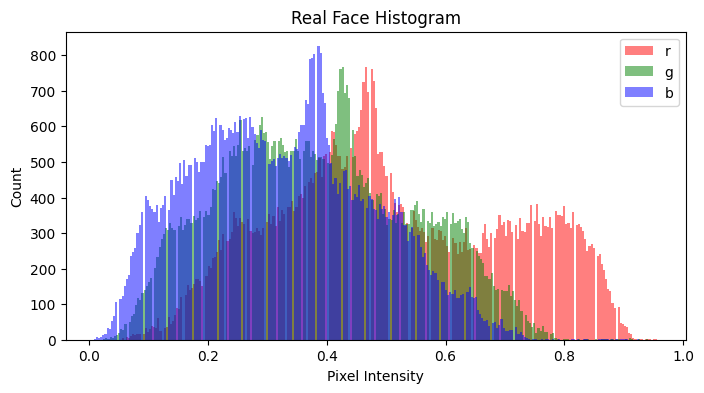

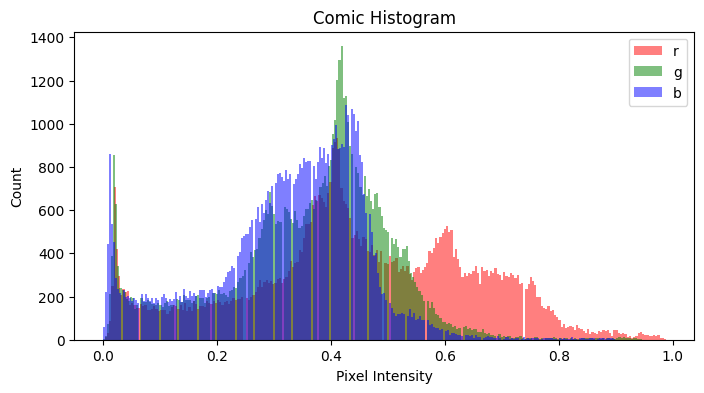

In [10]:
for batch in dataloader:
    plot_pixel_histogram(batch['face'], title="Real Face Histogram")
    plot_pixel_histogram(batch['comic'], title="Comic Histogram")
    break

# Observation about RGB Pixels

We can see that there are a lot more colors in the comic images, which makes sense. Since, in the human images, there is a spike at 1.0, it would seem that the human images have a lot of white in them, perhaps the backgrounds are light color, or perhaps its the lighting
images are bright. This observation makes sense considering the images we saw in the earlier cells.

We can also see that there is a lot more red used in the comic images, this is probably due to skin color.

# Training models

We are going to be using cAN framework for this dataset.

### What is cGAN
A Conditional GAN (GAN) is a type of Generative Adversarial Network where both the generator and the discriminator receive extra information (like a label or an image) as input. Instead of generating completely random outputs, a GAN conditions the generation process based on
some specific input, allowing it to learn controlled mappings from input to output

### Why cAN for this dataset and task?

In this project, we are translating face photos into comic-style images. This is not a random generation task - it's a mapping task: We want each real face to correspond to a particular comic version.

## Models

We are going to be using 2 different architectures for the generators.

1. U-Net Generator - its encoder-decoder structure with skip connections helps preserve fine details (like facial features) while translating the image into comic style.
2. LightResNet Generator - a lightweight alternative to U-Net, offering faster training with fewer parameters while still capturing important transformations.

We are going to a PatchGAN Discriminator, for both types of generators. PatchGAN is used because it focuses on small image patches, encouraging sharper local details rather than just global realism, making it perfect for style transfer tasks

We are going to tuning the following hyperparameters

1. lambda_L1_values = [100, 200] - to balance how much the model prioritizes pixel-level accuracy (L1 loss) versus generating realistic textures (GAN loss)
2. learning_rate_values = [1e-4, 2e-4] - to find the best trade-off between faster convergence and stable training without collapsing the GAN.

I wanted to actually train a Reset generator, and I started training it. But it took too long, so I stopped that training, and went with LightResNet instead. Hopefully this gives us a decent model.

We are also going to training the models (4 in total for each generator architecture), over 50 epochs. I wanted to train this for more epochs, but again, there is a limitation on time and device.

### U-Net Generator

In [ ]:

def down_block(in_channels, out_channels, normalize=True):
    layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
    if normalize:
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)


def up_block(in_channels, out_channels, dropout=0.0):
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if dropout:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder
        self.d1 = down_block(3, 64, normalize=False)  
        self.d2 = down_block(64, 128)
        self.d3 = down_block(128, 256)
        self.d4 = down_block(256, 512)
        self.d5 = down_block(512, 512)
   
        self.u1 = up_block(512, 512)
        self.u2 = up_block(1024, 256)
        self.u3 = up_block(512, 128)
        self.u4 = up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
    
        d1_out = self.d1(x)
        d2_out = self.d2(d1_out)
        d3_out = self.d3(d2_out)
        d4_out = self.d4(d3_out)
        d5_out = self.d5(d4_out)

    
        u1_out = self.u1(d5_out)
        u1_out = torch.cat((u1_out, d4_out), dim=1)

        u2_out = self.u2(u1_out)
        u2_out = torch.cat((u2_out, d3_out), dim=1)

        u3_out = self.u3(u2_out)
        u3_out = torch.cat((u3_out, d2_out), dim=1)

        u4_out = self.u4(u3_out)
        u4_out = torch.cat((u4_out, d1_out), dim=1)

        output = self.final(u4_out)
        return output




### LightResNet Generator

In [12]:
def residual_block(in_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_channels)
    )

class LightResNetGenerator(nn.Module):
    def __init__(self):
        super(LightResNetGenerator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.res_blocks = nn.Sequential(
            residual_block(256),
            residual_block(256),
            residual_block(256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        e = self.encoder(x)
        r = self.res_blocks(e)
        out = self.decoder(r)
        return out

### PatchGAN Discriminator

In [13]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, stride=1, padding=1),
        )

    def forward(self, x_real, x_fake):
        x = torch.cat((x_real, x_fake), dim=1)
        return self.model(x)

## Loss Functions

For loss functions, I have decided to go with separate loss functions for the 2 generators.

1. For U-Net Generator, I went with a combined loss of GAN Loss + L1 Loss
2. For LightResNet Generator, I went with just the GAN Loss.

### LightResNet Loss Function

In [14]:
bce_loss = nn.BCEWithLogitsLoss()


def gan_loss(predicted, target_is_real):
    """Calculates standard GAN loss"""
    label_smooth = 0.1  
    if target_is_real:
        target = torch.ones_like(predicted) * (1 - label_smooth)  
    else:
        target = torch.zeros_like(predicted) + label_smooth  
    return bce_loss(predicted, target)

### U-Net Generator Loss Function

In [15]:
l1_loss = nn.L1Loss()

def unet_combined_loss(pred_fake, pred_real, fake_image, target_image, lambda_l1=100):
    """
    pred_fake: output from discriminator on fake images
    pred_real: output from discriminator on real images
    fake_image: generated image
    target_image: ground truth image
    """
    gan = gan_loss(pred_fake, True)  # Generator wants to fool the discriminator
    l1 = l1_loss(fake_image, target_image) * lambda_l1
    return gan + l1

In [16]:
def plot_loss_curves(loss_D_list, loss_G_list):
    epochs = range(len(loss_D_list))
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_D_list, label='Discriminator Loss')
    plt.title('Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_G_list, label='Generator Loss')
    plt.title('Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

In [17]:
def display_images(input_image, real_image, fake_image, epoch, num_images=1):
    input_image = input_image[:num_images].cpu().detach().numpy()
    real_image = real_image[:num_images].cpu().detach().numpy()
    fake_image = fake_image[:num_images].cpu().detach().numpy()

    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(input_image[i].transpose(1, 2, 0))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(real_image[i].transpose(1, 2, 0))
        plt.title('Real Image')
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(fake_image[i].transpose(1, 2, 0))
        plt.title(f'Generated Image (Epoch {epoch})')
        plt.axis('off')

    plt.show()

In [18]:
def train_model(generator, discriminator, dataloader, num_epochs=100, device='cuda', lambda_l1=100, learning_rate=2e-4, use_l1=True):
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    opt_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    opt_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    loss_D_list = []
    loss_G_list = []

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        epoch_loss_D = 0
        epoch_loss_G = 0
        for idx, data in enumerate(dataloader):
            input_image = data['face'].to(device)
            target_image = data['comic'].to(device)

            opt_D.zero_grad()

            pred_real = discriminator(input_image, target_image)
            loss_real = gan_loss(pred_real, True)

            fake_image = generator(input_image)
            pred_fake = discriminator(input_image, fake_image.detach())  
            loss_fake = gan_loss(pred_fake, False)

            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            opt_D.step()
            epoch_loss_D += loss_D.item()

            opt_G.zero_grad()


            pred_fake_for_g = discriminator(input_image, fake_image)
            if use_l1:
                loss_G = unet_combined_loss(pred_fake_for_g, pred_real, fake_image, target_image, lambda_l1)
            else:
                loss_G = gan_loss(pred_fake_for_g, True)

            loss_G.backward()
            opt_G.step()
            epoch_loss_G += loss_G.item()

            if idx % 50 == 0:
                print(f"Epoch {epoch}/{num_epochs} Batch {idx}/{len(dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

        loss_D_list.append(epoch_loss_D / len(dataloader))
        loss_G_list.append(epoch_loss_G / len(dataloader))

        if epoch % 5 == 0:
            display_images(input_image, target_image, fake_image, epoch)

    plot_loss_curves(loss_D_list, loss_G_list)
    return loss_D_list, loss_G_list

In [19]:
unet_generator = UNetGenerator()
lightresnet_generator = LightResNetGenerator()
discriminator = PatchGANDiscriminator()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


In [20]:
lambda_L1_values = [100, 200]  
learning_rate_values = [1e-4, 2e-4]  

In [21]:
# Main function to perform hyperparameter tuning
def hyperparameter_tuning(generator, discriminator, dataloader, device='cuda', num_epochs=50, use_l1=True):
    best_loss = float('inf')
    best_params = None

    # Iterate over all combinations of hyperparameters
    for lambda_L1 in lambda_L1_values:
        for learning_rate in learning_rate_values:
            print(f"\nTraining with lambda_L1={lambda_L1}, learning_rate={learning_rate}")
            # generator = generator.class_()  # Assuming a function that returns a new generator model
            # Set up optimizers with the current learning rate
            # opt_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

            # Train the model with current hyperparameters
            loss_D_list, loss_G_list = train_model(generator, discriminator, dataloader, num_epochs, device, lambda_L1, learning_rate, use_l1)

            # Use the final generator loss as a performance measure (can be modified for your needs)
            final_loss_G = loss_G_list[-1]  # Get the final generator loss

            # Update best parameters based on loss
            if final_loss_G < best_loss:
                best_loss = final_loss_G
                best_params = {
                    'lambda_L1': lambda_L1,
                    'learning_rate': learning_rate
                }
                
            # Visualize losses (this can also be adjusted as needed)
            plot_loss_curves(loss_D_list, loss_G_list)

    print(f"\nBest Parameters: lambda_L1={best_params['lambda_L1']}, learning_rate={best_params['learning_rate']}")
    return best_params

### U-Net Model Training


Training with lambda_L1=100, learning_rate=0.0001


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.7113 Loss_G: 68.4003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999927..1.0].


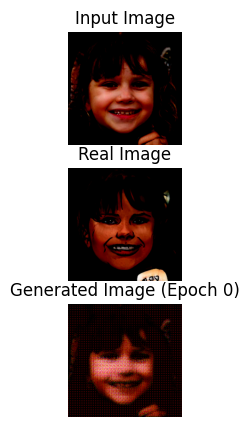

Training Epochs:   2%|▏         | 1/50 [00:24<19:45, 24.20s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.5508 Loss_G: 30.7434


Training Epochs:   4%|▍         | 2/50 [00:48<19:26, 24.31s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.5469 Loss_G: 27.1847


Training Epochs:   6%|▌         | 3/50 [01:13<19:06, 24.39s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.4345 Loss_G: 27.2075


Training Epochs:   8%|▊         | 4/50 [01:37<18:36, 24.27s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.4090 Loss_G: 25.2856


Training Epochs:  10%|█         | 5/50 [02:01<18:15, 24.33s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.4405 Loss_G: 23.8973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9925548..1.0].


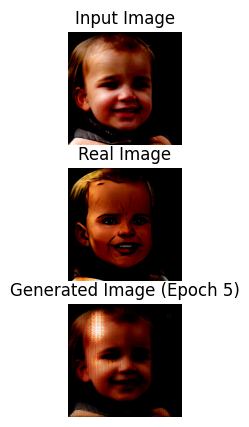

Training Epochs:  12%|█▏        | 6/50 [02:26<17:52, 24.39s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.3652 Loss_G: 25.2499


Training Epochs:  14%|█▍        | 7/50 [02:50<17:27, 24.35s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.3525 Loss_G: 26.2006


Training Epochs:  16%|█▌        | 8/50 [03:14<17:05, 24.43s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.4696 Loss_G: 22.3969


Training Epochs:  18%|█▊        | 9/50 [03:39<16:44, 24.49s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.3405 Loss_G: 28.8994


Training Epochs:  20%|██        | 10/50 [04:04<16:20, 24.50s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.3349 Loss_G: 26.1193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9957712..0.7758802].


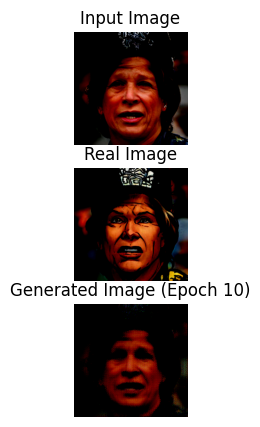

Training Epochs:  22%|██▏       | 11/50 [04:28<15:57, 24.54s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.3781 Loss_G: 25.0016


Training Epochs:  24%|██▍       | 12/50 [04:53<15:31, 24.52s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.4753 Loss_G: 26.9637


Training Epochs:  26%|██▌       | 13/50 [05:17<15:07, 24.52s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.6012 Loss_G: 27.3294


Training Epochs:  28%|██▊       | 14/50 [05:42<14:44, 24.57s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.3411 Loss_G: 24.3274


Training Epochs:  30%|███       | 15/50 [06:06<14:18, 24.53s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.4000 Loss_G: 22.7819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99751097..0.9998335].


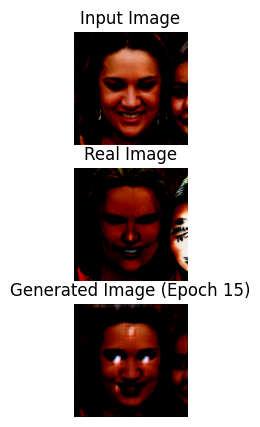

Training Epochs:  32%|███▏      | 16/50 [06:31<13:53, 24.51s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.3535 Loss_G: 25.3208


Training Epochs:  34%|███▍      | 17/50 [06:55<13:29, 24.52s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.3745 Loss_G: 23.2912


Training Epochs:  36%|███▌      | 18/50 [07:20<13:03, 24.48s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.4637 Loss_G: 21.3978


Training Epochs:  38%|███▊      | 19/50 [07:44<12:38, 24.46s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.3486 Loss_G: 23.4632


Training Epochs:  40%|████      | 20/50 [08:09<12:14, 24.48s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.4594 Loss_G: 22.1869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99940115..0.849676].


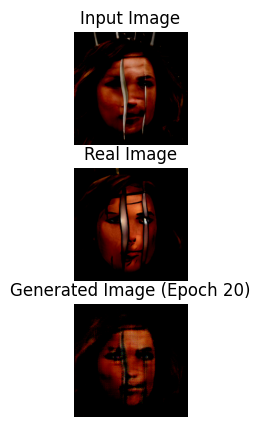

Training Epochs:  42%|████▏     | 21/50 [08:33<11:48, 24.44s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.5871 Loss_G: 22.8991


Training Epochs:  44%|████▍     | 22/50 [08:58<11:26, 24.52s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.4356 Loss_G: 20.7714


Training Epochs:  46%|████▌     | 23/50 [09:22<11:03, 24.58s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.6919 Loss_G: 21.0062


Training Epochs:  48%|████▊     | 24/50 [09:47<10:40, 24.63s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.4252 Loss_G: 22.2700


Training Epochs:  50%|█████     | 25/50 [10:12<10:17, 24.70s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.4046 Loss_G: 21.7665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999221..0.95376664].


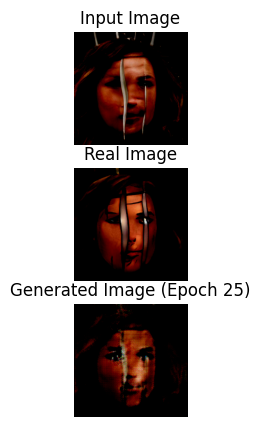

Training Epochs:  52%|█████▏    | 26/50 [10:37<09:52, 24.70s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.3911 Loss_G: 21.4983


Training Epochs:  54%|█████▍    | 27/50 [11:01<09:26, 24.64s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.9265 Loss_G: 16.5179


Training Epochs:  56%|█████▌    | 28/50 [11:26<09:02, 24.66s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.3792 Loss_G: 19.8088


Training Epochs:  58%|█████▊    | 29/50 [11:51<08:38, 24.68s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.4338 Loss_G: 17.8050


Training Epochs:  60%|██████    | 30/50 [12:15<08:13, 24.68s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.4503 Loss_G: 14.7946


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99950385..0.9982413].


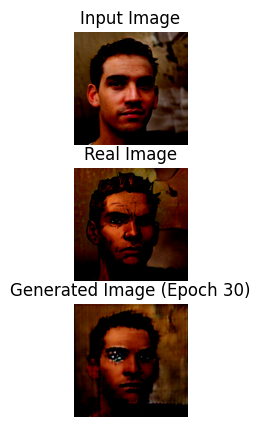

Training Epochs:  62%|██████▏   | 31/50 [12:40<07:48, 24.67s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.4173 Loss_G: 16.3392


Training Epochs:  64%|██████▍   | 32/50 [13:05<07:23, 24.62s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.5167 Loss_G: 17.4359


Training Epochs:  66%|██████▌   | 33/50 [13:29<06:57, 24.59s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.8230 Loss_G: 15.4767


Training Epochs:  68%|██████▊   | 34/50 [13:54<06:33, 24.61s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.6658 Loss_G: 14.5260


Training Epochs:  70%|███████   | 35/50 [14:18<06:08, 24.57s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.4430 Loss_G: 16.3077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99954313..0.9641962].


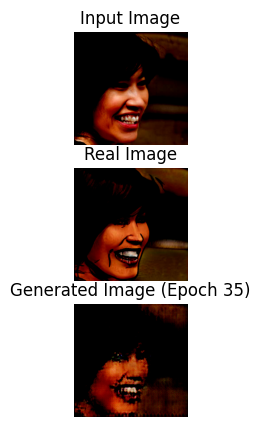

Training Epochs:  72%|███████▏  | 36/50 [14:43<05:44, 24.58s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.5762 Loss_G: 14.8090


Training Epochs:  74%|███████▍  | 37/50 [15:07<05:19, 24.57s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.8621 Loss_G: 13.8277


Training Epochs:  76%|███████▌  | 38/50 [15:32<04:55, 24.59s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.4691 Loss_G: 14.1857


Training Epochs:  78%|███████▊  | 39/50 [15:56<04:29, 24.46s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.4131 Loss_G: 15.0417


Training Epochs:  80%|████████  | 40/50 [16:21<04:04, 24.47s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.5063 Loss_G: 12.6681


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998055..0.9617855].


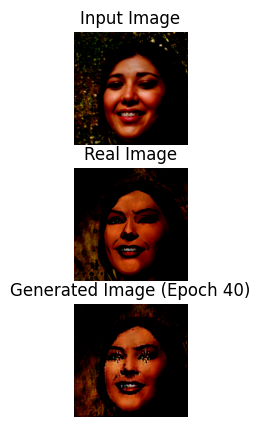

Training Epochs:  82%|████████▏ | 41/50 [16:45<03:40, 24.47s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.4573 Loss_G: 14.2855


Training Epochs:  84%|████████▍ | 42/50 [17:10<03:15, 24.48s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.5902 Loss_G: 14.0465


Training Epochs:  86%|████████▌ | 43/50 [17:34<02:51, 24.52s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.7464 Loss_G: 12.6038


Training Epochs:  88%|████████▊ | 44/50 [17:59<02:27, 24.50s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.4902 Loss_G: 13.2469


Training Epochs:  90%|█████████ | 45/50 [18:23<02:02, 24.53s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.5690 Loss_G: 12.6892


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99897605..0.9638187].


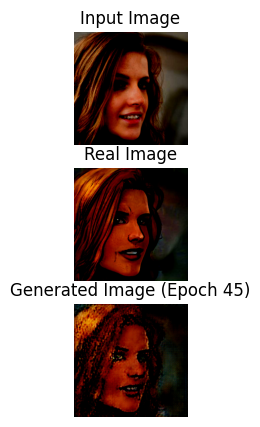

Training Epochs:  92%|█████████▏| 46/50 [18:48<01:38, 24.50s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.4883 Loss_G: 14.8003


Training Epochs:  94%|█████████▍| 47/50 [19:12<01:13, 24.48s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.5031 Loss_G: 13.2127


Training Epochs:  96%|█████████▌| 48/50 [19:37<00:48, 24.46s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.6259 Loss_G: 12.0651


Training Epochs:  98%|█████████▊| 49/50 [20:01<00:24, 24.47s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.4692 Loss_G: 11.6441


Training Epochs: 100%|██████████| 50/50 [20:25<00:00, 24.52s/it]


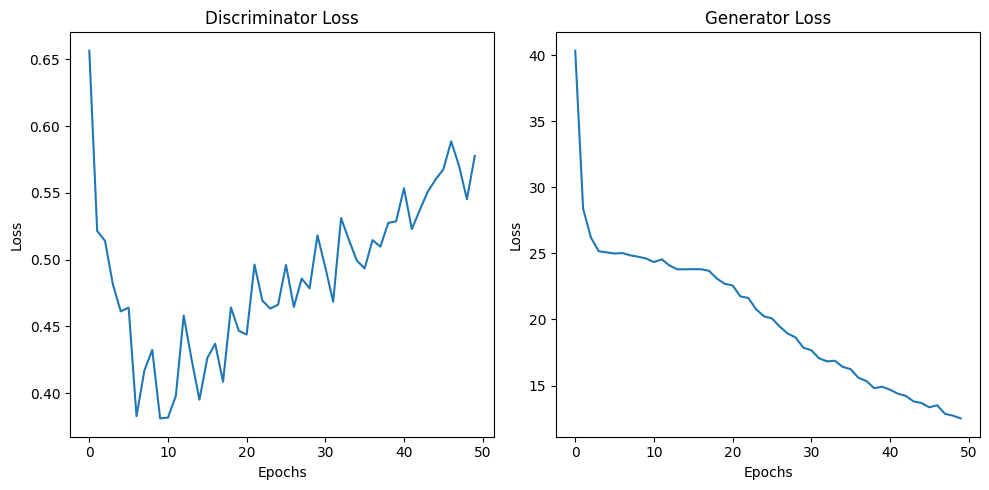

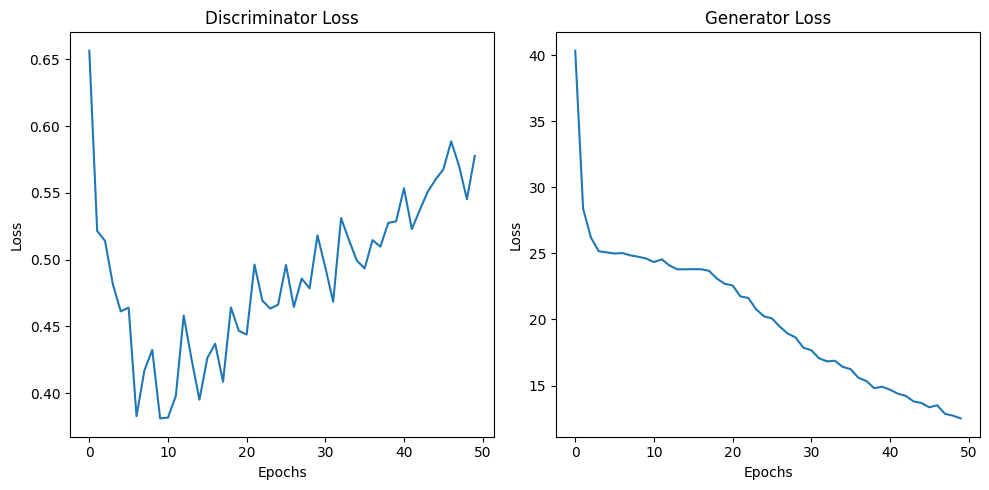


Training with lambda_L1=100, learning_rate=0.0002


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.5449 Loss_G: 12.2978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9996361..0.9835234].


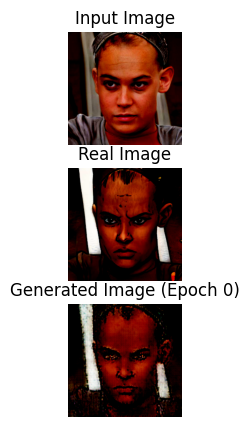

Training Epochs:   2%|▏         | 1/50 [00:24<20:00, 24.51s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.5224 Loss_G: 13.6219


Training Epochs:   4%|▍         | 2/50 [00:49<19:42, 24.64s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.7257 Loss_G: 12.6422


Training Epochs:   6%|▌         | 3/50 [01:14<19:22, 24.73s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.5443 Loss_G: 12.6422


Training Epochs:   8%|▊         | 4/50 [01:38<18:59, 24.77s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.7992 Loss_G: 11.5896


Training Epochs:  10%|█         | 5/50 [02:03<18:32, 24.72s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.5018 Loss_G: 12.5685


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998753..0.988276].


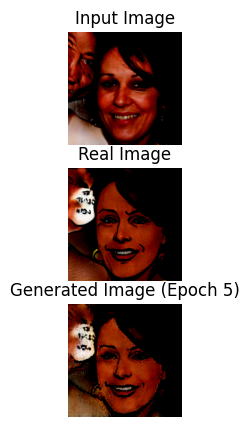

Training Epochs:  12%|█▏        | 6/50 [02:28<18:06, 24.69s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.5559 Loss_G: 12.8221


Training Epochs:  14%|█▍        | 7/50 [02:52<17:41, 24.69s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.5296 Loss_G: 10.4886


Training Epochs:  16%|█▌        | 8/50 [03:17<17:15, 24.66s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.5293 Loss_G: 10.7477


Training Epochs:  18%|█▊        | 9/50 [03:42<16:51, 24.67s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.5814 Loss_G: 11.1377


Training Epochs:  20%|██        | 10/50 [04:06<16:28, 24.72s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.5418 Loss_G: 9.9874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9990274..0.98990536].


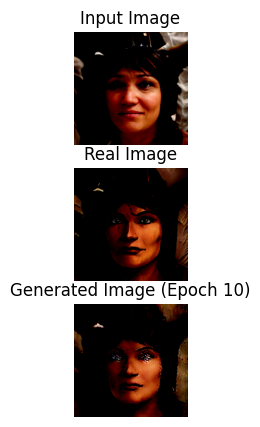

Training Epochs:  22%|██▏       | 11/50 [04:31<16:03, 24.71s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.5711 Loss_G: 12.2450


Training Epochs:  24%|██▍       | 12/50 [04:56<15:39, 24.72s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.5846 Loss_G: 10.1700


Training Epochs:  26%|██▌       | 13/50 [05:21<15:14, 24.71s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.6851 Loss_G: 9.7057


Training Epochs:  28%|██▊       | 14/50 [05:45<14:49, 24.72s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.6921 Loss_G: 9.5976


Training Epochs:  30%|███       | 15/50 [06:10<14:23, 24.66s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.4737 Loss_G: 11.7944


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9994835..0.8377643].


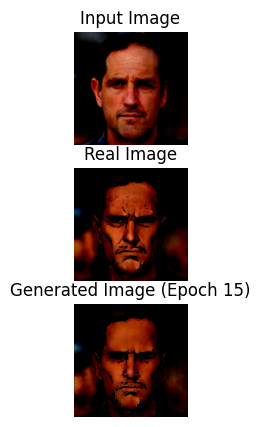

Training Epochs:  32%|███▏      | 16/50 [06:35<13:59, 24.71s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.4633 Loss_G: 11.3893


Training Epochs:  34%|███▍      | 17/50 [06:59<13:34, 24.68s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.6075 Loss_G: 10.2862


Training Epochs:  36%|███▌      | 18/50 [07:24<13:07, 24.62s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.7082 Loss_G: 11.0598


Training Epochs:  38%|███▊      | 19/50 [07:48<12:43, 24.61s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.6482 Loss_G: 10.7224


Training Epochs:  40%|████      | 20/50 [08:13<12:18, 24.62s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.6546 Loss_G: 9.8454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999976..0.9767032].


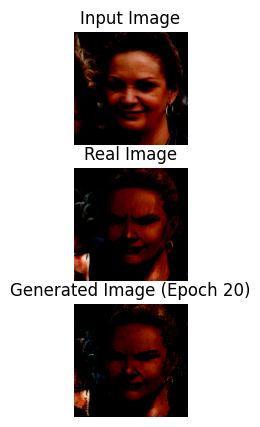

Training Epochs:  42%|████▏     | 21/50 [08:38<11:56, 24.70s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.4806 Loss_G: 10.5340


Training Epochs:  44%|████▍     | 22/50 [09:03<11:31, 24.69s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.5491 Loss_G: 9.2635


Training Epochs:  46%|████▌     | 23/50 [09:27<11:06, 24.67s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.5971 Loss_G: 9.4356


Training Epochs:  48%|████▊     | 24/50 [09:52<10:41, 24.66s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.5526 Loss_G: 10.5049


Training Epochs:  50%|█████     | 25/50 [10:16<10:14, 24.60s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.4162 Loss_G: 10.9397


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999964..0.8456105].


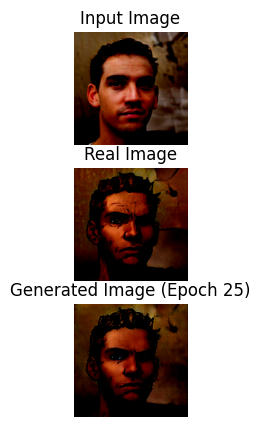

Training Epochs:  52%|█████▏    | 26/50 [10:41<09:49, 24.55s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.6036 Loss_G: 10.1445


Training Epochs:  54%|█████▍    | 27/50 [11:05<09:25, 24.58s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.6625 Loss_G: 10.3885


Training Epochs:  56%|█████▌    | 28/50 [11:30<09:01, 24.62s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.5978 Loss_G: 7.8991


Training Epochs:  58%|█████▊    | 29/50 [11:55<08:38, 24.67s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.5650 Loss_G: 7.9471


Training Epochs:  60%|██████    | 30/50 [12:20<08:13, 24.68s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.5872 Loss_G: 8.3963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99991465..0.9308019].


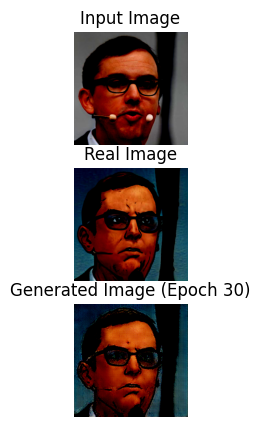

Training Epochs:  62%|██████▏   | 31/50 [12:44<07:48, 24.67s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.5124 Loss_G: 12.0614


Training Epochs:  64%|██████▍   | 32/50 [13:09<07:23, 24.66s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.6421 Loss_G: 8.7954


Training Epochs:  66%|██████▌   | 33/50 [13:34<06:59, 24.68s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.4804 Loss_G: 8.9334


Training Epochs:  68%|██████▊   | 34/50 [13:58<06:35, 24.72s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.5279 Loss_G: 9.3035


Training Epochs:  70%|███████   | 35/50 [14:23<06:11, 24.74s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.3534 Loss_G: 9.8698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9828917].


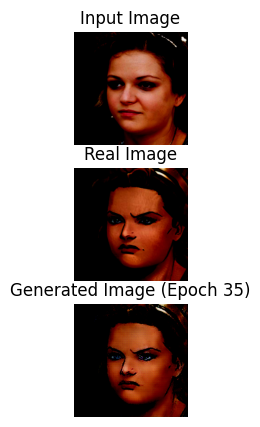

Training Epochs:  72%|███████▏  | 36/50 [14:48<05:46, 24.76s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.3972 Loss_G: 8.8387


Training Epochs:  74%|███████▍  | 37/50 [15:13<05:21, 24.71s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.4842 Loss_G: 8.6837


Training Epochs:  76%|███████▌  | 38/50 [15:37<04:56, 24.68s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.3357 Loss_G: 8.7564


Training Epochs:  78%|███████▊  | 39/50 [16:02<04:31, 24.66s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.3679 Loss_G: 9.0777


Training Epochs:  80%|████████  | 40/50 [16:26<04:06, 24.67s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.3281 Loss_G: 9.4248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99971765..0.99717826].


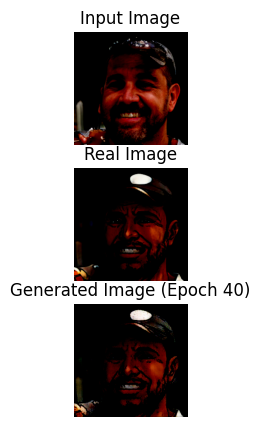

Training Epochs:  82%|████████▏ | 41/50 [16:51<03:41, 24.65s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.4739 Loss_G: 9.1236


Training Epochs:  84%|████████▍ | 42/50 [17:16<03:17, 24.64s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.3348 Loss_G: 8.8869


Training Epochs:  86%|████████▌ | 43/50 [17:40<02:52, 24.67s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.3538 Loss_G: 9.3966


Training Epochs:  88%|████████▊ | 44/50 [18:05<02:28, 24.69s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.3306 Loss_G: 8.2681


Training Epochs:  90%|█████████ | 45/50 [18:30<02:03, 24.72s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.3279 Loss_G: 9.1971


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99816847..0.9139694].


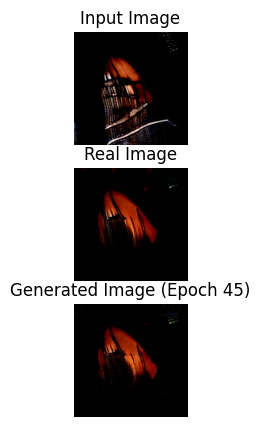

Training Epochs:  92%|█████████▏| 46/50 [18:55<01:38, 24.74s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.3285 Loss_G: 8.8685


Training Epochs:  94%|█████████▍| 47/50 [19:19<01:14, 24.70s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.3306 Loss_G: 8.3339


Training Epochs:  96%|█████████▌| 48/50 [19:44<00:49, 24.73s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.3271 Loss_G: 8.1722


Training Epochs:  98%|█████████▊| 49/50 [20:09<00:24, 24.68s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.3297 Loss_G: 8.7118


Training Epochs: 100%|██████████| 50/50 [20:33<00:00, 24.68s/it]


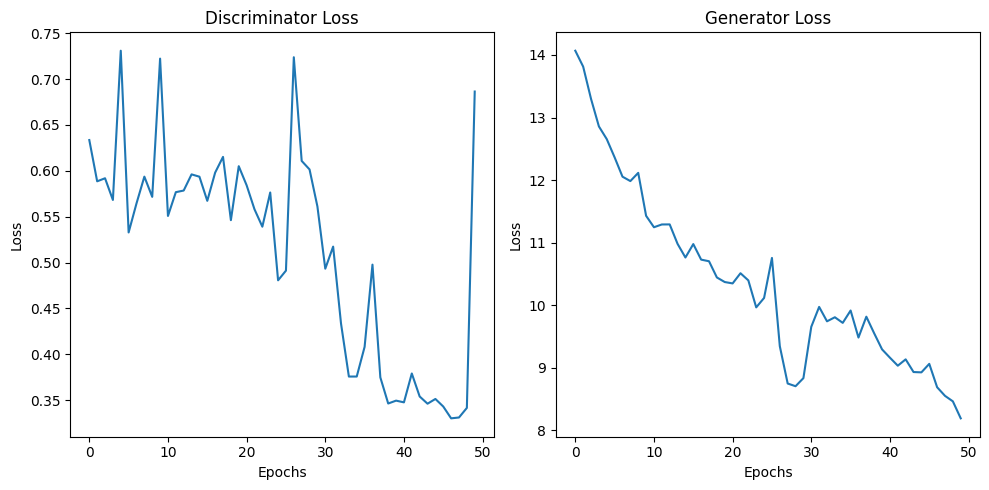

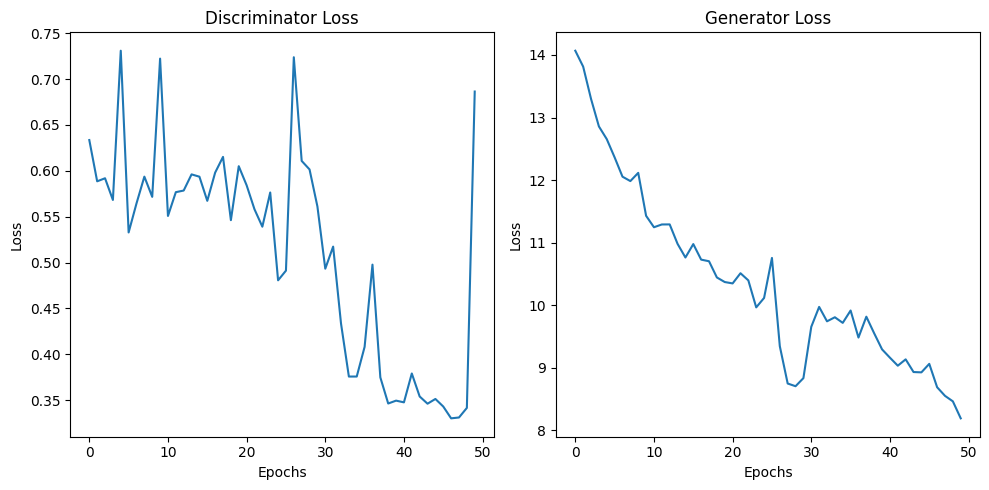


Training with lambda_L1=200, learning_rate=0.0001


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.3610 Loss_G: 14.8120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999678..0.9068586].


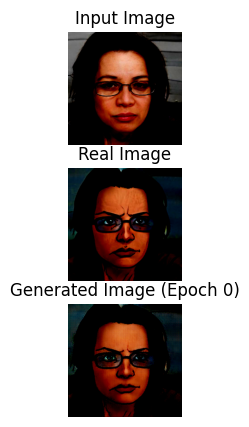

Training Epochs:   2%|▏         | 1/50 [00:24<19:43, 24.16s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.6217 Loss_G: 12.4692


Training Epochs:   4%|▍         | 2/50 [00:48<19:26, 24.30s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.5447 Loss_G: 13.0040


Training Epochs:   6%|▌         | 3/50 [01:13<19:05, 24.38s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.3790 Loss_G: 11.9161


Training Epochs:   8%|▊         | 4/50 [01:37<18:43, 24.42s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.4410 Loss_G: 14.0382


Training Epochs:  10%|█         | 5/50 [02:01<18:15, 24.35s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.3772 Loss_G: 15.0980


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99954146..0.9574578].


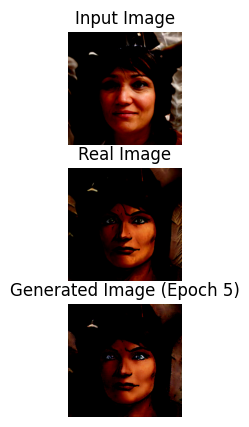

Training Epochs:  12%|█▏        | 6/50 [02:26<17:54, 24.41s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.4213 Loss_G: 12.0158


Training Epochs:  14%|█▍        | 7/50 [02:50<17:31, 24.44s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.3317 Loss_G: 14.1791


Training Epochs:  16%|█▌        | 8/50 [03:15<17:09, 24.51s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.4549 Loss_G: 12.6209


Training Epochs:  18%|█▊        | 9/50 [03:40<16:47, 24.56s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.4513 Loss_G: 11.7430


Training Epochs:  20%|██        | 10/50 [04:04<16:22, 24.57s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.3954 Loss_G: 11.1407


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9995693..0.946913].


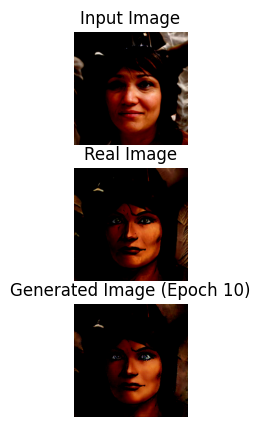

Training Epochs:  22%|██▏       | 11/50 [04:29<15:59, 24.60s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.5832 Loss_G: 13.3950


Training Epochs:  24%|██▍       | 12/50 [04:53<15:32, 24.53s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.4346 Loss_G: 12.3391


Training Epochs:  26%|██▌       | 13/50 [05:18<15:08, 24.55s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.3739 Loss_G: 14.5685


Training Epochs:  28%|██▊       | 14/50 [05:42<14:44, 24.57s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.4209 Loss_G: 13.6093


Training Epochs:  30%|███       | 15/50 [06:07<14:20, 24.60s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.4362 Loss_G: 12.1605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999183..0.9498822].


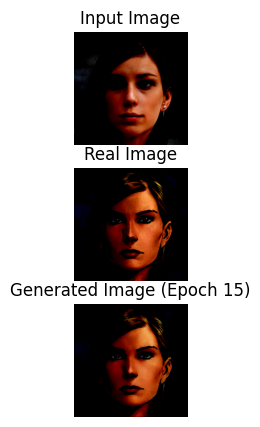

Training Epochs:  32%|███▏      | 16/50 [06:32<13:55, 24.58s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.3747 Loss_G: 12.5437


Training Epochs:  34%|███▍      | 17/50 [06:56<13:29, 24.53s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.3379 Loss_G: 12.6401


Training Epochs:  36%|███▌      | 18/50 [07:21<13:05, 24.56s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.3484 Loss_G: 13.2605


Training Epochs:  38%|███▊      | 19/50 [07:45<12:41, 24.58s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.3437 Loss_G: 12.4270


Training Epochs:  40%|████      | 20/50 [08:10<12:17, 24.58s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.5850 Loss_G: 11.5283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999285..0.90338534].


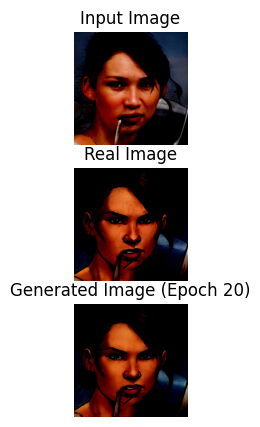

Training Epochs:  42%|████▏     | 21/50 [08:34<11:52, 24.58s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.3746 Loss_G: 11.7486


Training Epochs:  44%|████▍     | 22/50 [08:59<11:29, 24.64s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.3551 Loss_G: 13.2843


Training Epochs:  46%|████▌     | 23/50 [09:24<11:05, 24.63s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.3792 Loss_G: 12.2466


Training Epochs:  48%|████▊     | 24/50 [09:48<10:36, 24.48s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.3377 Loss_G: 12.5182


Training Epochs:  50%|█████     | 25/50 [10:13<10:12, 24.49s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.3898 Loss_G: 11.7968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999356..0.9815876].


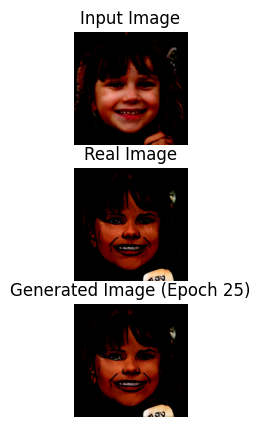

Training Epochs:  52%|█████▏    | 26/50 [10:37<09:48, 24.51s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.3457 Loss_G: 11.6926


Training Epochs:  54%|█████▍    | 27/50 [11:02<09:23, 24.51s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.3294 Loss_G: 11.8213


Training Epochs:  56%|█████▌    | 28/50 [11:26<08:58, 24.49s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.3279 Loss_G: 10.8382


Training Epochs:  58%|█████▊    | 29/50 [11:51<08:34, 24.49s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.4185 Loss_G: 11.0359


Training Epochs:  60%|██████    | 30/50 [12:15<08:09, 24.49s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.3730 Loss_G: 11.9736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.95723975].


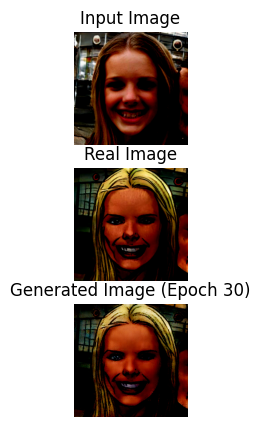

Training Epochs:  62%|██████▏   | 31/50 [12:40<07:45, 24.52s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.4333 Loss_G: 12.4210


Training Epochs:  64%|██████▍   | 32/50 [13:04<07:21, 24.54s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.4035 Loss_G: 12.6713


Training Epochs:  66%|██████▌   | 33/50 [13:29<06:56, 24.51s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.3560 Loss_G: 12.0395


Training Epochs:  68%|██████▊   | 34/50 [13:53<06:32, 24.50s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.3343 Loss_G: 10.9925


Training Epochs:  70%|███████   | 35/50 [14:18<06:07, 24.51s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.3323 Loss_G: 13.5557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9997238..0.9408613].


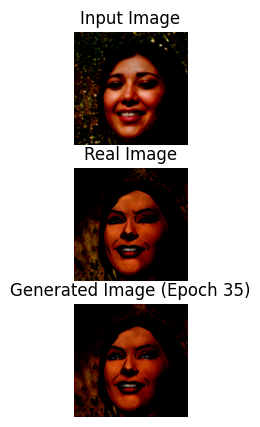

Training Epochs:  72%|███████▏  | 36/50 [14:42<05:44, 24.58s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.3488 Loss_G: 11.6220


Training Epochs:  74%|███████▍  | 37/50 [15:07<05:19, 24.54s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.3304 Loss_G: 11.8154


Training Epochs:  76%|███████▌  | 38/50 [15:31<04:54, 24.56s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.3321 Loss_G: 11.1119


Training Epochs:  78%|███████▊  | 39/50 [15:56<04:30, 24.58s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.3381 Loss_G: 13.3171


Training Epochs:  80%|████████  | 40/50 [16:21<04:06, 24.60s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.3353 Loss_G: 10.3441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92945415].


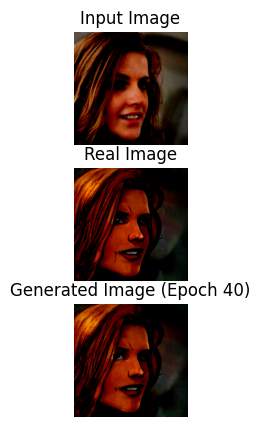

Training Epochs:  82%|████████▏ | 41/50 [16:45<03:41, 24.63s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.3307 Loss_G: 12.2652


Training Epochs:  84%|████████▍ | 42/50 [17:10<03:17, 24.64s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.3309 Loss_G: 11.0727


Training Epochs:  86%|████████▌ | 43/50 [17:35<02:52, 24.61s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.3282 Loss_G: 10.0766


Training Epochs:  88%|████████▊ | 44/50 [17:59<02:27, 24.51s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.3272 Loss_G: 10.0430


Training Epochs:  90%|█████████ | 45/50 [18:23<02:02, 24.51s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.3271 Loss_G: 11.3397


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9733173].


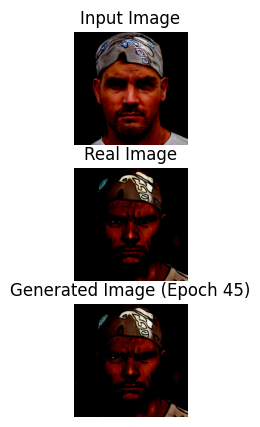

Training Epochs:  92%|█████████▏| 46/50 [18:48<01:37, 24.47s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.3278 Loss_G: 10.0650


Training Epochs:  94%|█████████▍| 47/50 [19:12<01:13, 24.54s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.3293 Loss_G: 10.4288


Training Epochs:  96%|█████████▌| 48/50 [19:37<00:49, 24.56s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.3266 Loss_G: 10.9233


Training Epochs:  98%|█████████▊| 49/50 [20:02<00:24, 24.62s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.3273 Loss_G: 11.3537


Training Epochs: 100%|██████████| 50/50 [20:27<00:00, 24.54s/it]


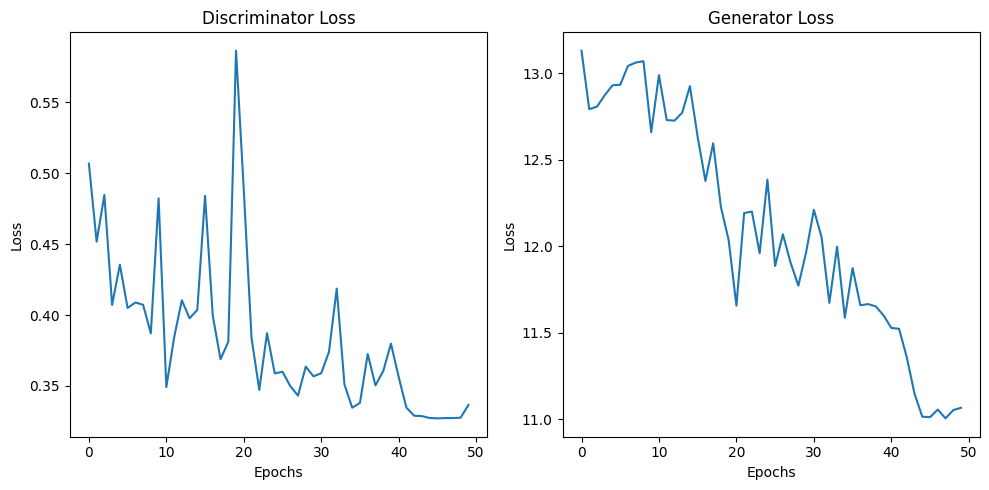

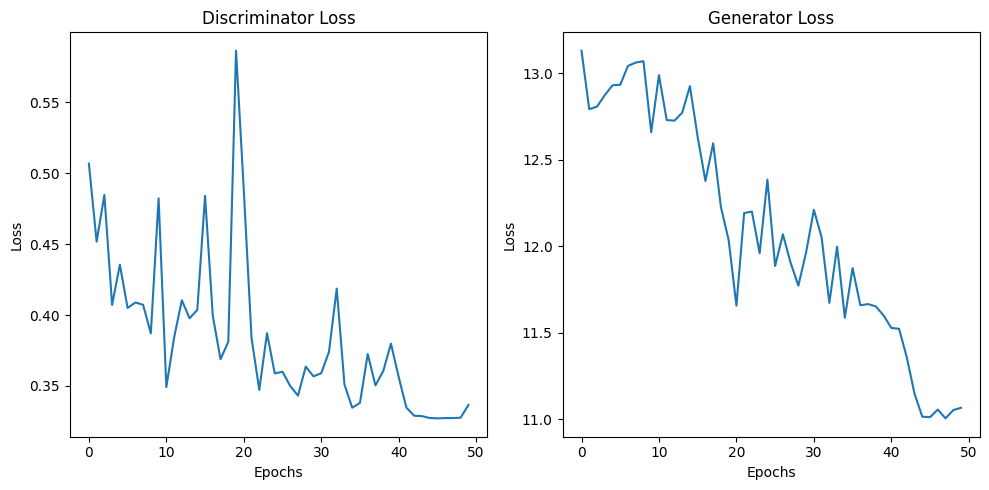


Training with lambda_L1=200, learning_rate=0.0002


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.3276 Loss_G: 11.9059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999979..0.77314603].


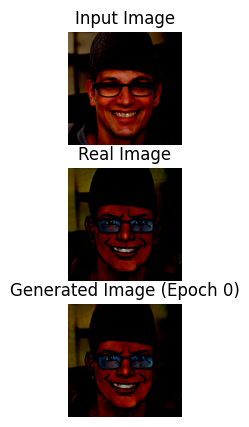

Training Epochs:   2%|▏         | 1/50 [00:24<20:14, 24.78s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.3615 Loss_G: 13.5538


Training Epochs:   4%|▍         | 2/50 [00:49<19:48, 24.77s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.3285 Loss_G: 14.0592


Training Epochs:   6%|▌         | 3/50 [01:14<19:24, 24.78s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.3286 Loss_G: 12.4843


Training Epochs:   8%|▊         | 4/50 [01:39<19:00, 24.79s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.3273 Loss_G: 12.5686


Training Epochs:  10%|█         | 5/50 [02:03<18:33, 24.74s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.3281 Loss_G: 13.2649


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999996..0.9350197].


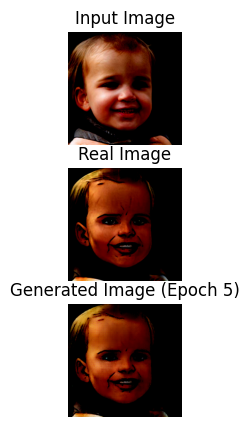

Training Epochs:  12%|█▏        | 6/50 [02:28<18:08, 24.73s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.3259 Loss_G: 12.0805


Training Epochs:  14%|█▍        | 7/50 [02:53<17:41, 24.68s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.3354 Loss_G: 12.7316


Training Epochs:  16%|█▌        | 8/50 [03:17<17:18, 24.74s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.3267 Loss_G: 12.0110


Training Epochs:  18%|█▊        | 9/50 [03:42<16:52, 24.69s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.3261 Loss_G: 12.9788


Training Epochs:  20%|██        | 10/50 [04:07<16:27, 24.70s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.3267 Loss_G: 12.2724


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9061716].


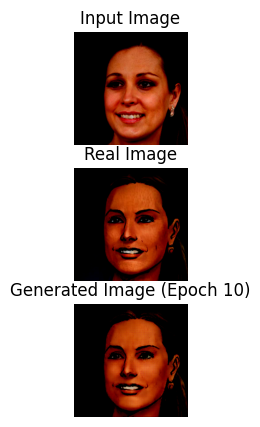

Training Epochs:  22%|██▏       | 11/50 [04:31<16:02, 24.69s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.3262 Loss_G: 13.3464


Training Epochs:  24%|██▍       | 12/50 [04:56<15:39, 24.71s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.3560 Loss_G: 11.4612


Training Epochs:  26%|██▌       | 13/50 [05:21<15:15, 24.74s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.3305 Loss_G: 12.8227


Training Epochs:  28%|██▊       | 14/50 [05:46<14:50, 24.73s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.3498 Loss_G: 11.3294


Training Epochs:  30%|███       | 15/50 [06:10<14:25, 24.73s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.4895 Loss_G: 13.2711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99364537..0.9795095].


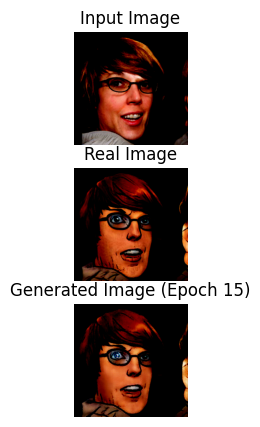

Training Epochs:  32%|███▏      | 16/50 [06:35<14:01, 24.76s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.6984 Loss_G: 9.6689


Training Epochs:  34%|███▍      | 17/50 [07:00<13:37, 24.76s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.6817 Loss_G: 10.3705


Training Epochs:  36%|███▌      | 18/50 [07:25<13:13, 24.80s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.6767 Loss_G: 11.2495


Training Epochs:  38%|███▊      | 19/50 [07:50<12:48, 24.78s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.7010 Loss_G: 9.8497


Training Epochs:  40%|████      | 20/50 [08:14<12:22, 24.74s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.6707 Loss_G: 11.3910


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9936611..0.9443846].


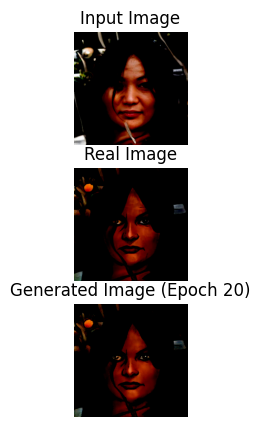

Training Epochs:  42%|████▏     | 21/50 [08:39<11:56, 24.72s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.6247 Loss_G: 12.1560


Training Epochs:  44%|████▍     | 22/50 [09:04<11:32, 24.71s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.6130 Loss_G: 10.2775


Training Epochs:  46%|████▌     | 23/50 [09:28<11:08, 24.75s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.6129 Loss_G: 10.0010


Training Epochs:  48%|████▊     | 24/50 [09:53<10:43, 24.75s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.6565 Loss_G: 10.0541


Training Epochs:  50%|█████     | 25/50 [10:18<10:18, 24.73s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.5809 Loss_G: 11.8454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999999..0.9484829].


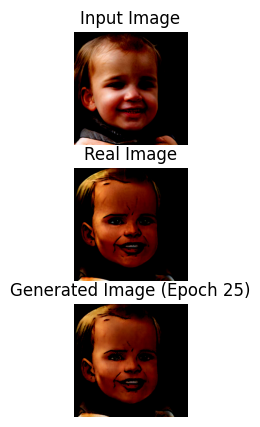

Training Epochs:  52%|█████▏    | 26/50 [10:42<09:52, 24.67s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.5115 Loss_G: 12.0678


Training Epochs:  54%|█████▍    | 27/50 [11:07<09:25, 24.60s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.5551 Loss_G: 9.7039


Training Epochs:  56%|█████▌    | 28/50 [11:32<09:02, 24.65s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.5151 Loss_G: 11.1246


Training Epochs:  58%|█████▊    | 29/50 [11:57<08:38, 24.71s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.6224 Loss_G: 9.3614


Training Epochs:  60%|██████    | 30/50 [12:21<08:15, 24.76s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.5643 Loss_G: 9.4587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999756..0.92438084].


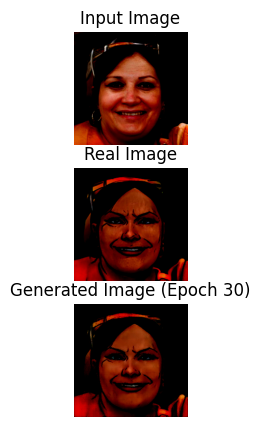

Training Epochs:  62%|██████▏   | 31/50 [12:46<07:51, 24.79s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.5875 Loss_G: 11.0429


Training Epochs:  64%|██████▍   | 32/50 [13:11<07:25, 24.77s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.5310 Loss_G: 12.5056


Training Epochs:  66%|██████▌   | 33/50 [13:36<07:01, 24.78s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.5992 Loss_G: 11.6840


Training Epochs:  68%|██████▊   | 34/50 [14:01<06:36, 24.77s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.6186 Loss_G: 10.3527


Training Epochs:  70%|███████   | 35/50 [14:25<06:11, 24.76s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.5523 Loss_G: 11.3975


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99989045..0.9679647].


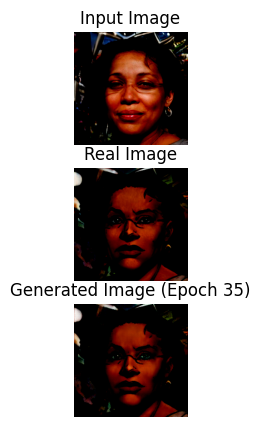

Training Epochs:  72%|███████▏  | 36/50 [14:50<05:47, 24.86s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.6419 Loss_G: 10.3439


Training Epochs:  74%|███████▍  | 37/50 [15:15<05:23, 24.92s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.3349 Loss_G: 11.5096


Training Epochs:  76%|███████▌  | 38/50 [15:40<04:58, 24.85s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.3332 Loss_G: 10.5826


Training Epochs:  78%|███████▊  | 39/50 [16:05<04:33, 24.84s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.3319 Loss_G: 12.8441


Training Epochs:  80%|████████  | 40/50 [16:30<04:08, 24.84s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.3337 Loss_G: 11.9797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999986..0.9151375].


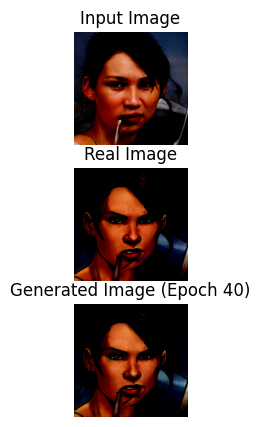

Training Epochs:  82%|████████▏ | 41/50 [16:55<03:43, 24.88s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.3303 Loss_G: 11.1469


Training Epochs:  84%|████████▍ | 42/50 [17:19<03:18, 24.79s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.6525 Loss_G: 9.0005


Training Epochs:  86%|████████▌ | 43/50 [17:44<02:53, 24.72s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.5897 Loss_G: 10.0214


Training Epochs:  88%|████████▊ | 44/50 [18:08<02:27, 24.65s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.5995 Loss_G: 8.8994


Training Epochs:  90%|█████████ | 45/50 [18:33<02:03, 24.71s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.5924 Loss_G: 10.7771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998946..0.9289512].


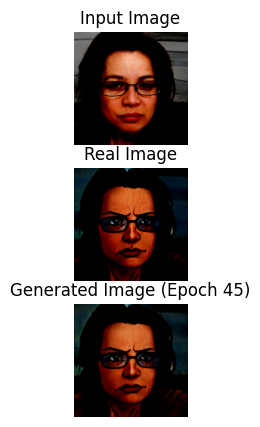

Training Epochs:  92%|█████████▏| 46/50 [18:58<01:39, 24.80s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.4750 Loss_G: 10.4437


Training Epochs:  94%|█████████▍| 47/50 [19:23<01:14, 24.76s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.3324 Loss_G: 11.0606


Training Epochs:  96%|█████████▌| 48/50 [19:48<00:49, 24.73s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.3334 Loss_G: 10.9359


Training Epochs:  98%|█████████▊| 49/50 [20:12<00:24, 24.71s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.3281 Loss_G: 11.2997


Training Epochs: 100%|██████████| 50/50 [20:37<00:00, 24.75s/it]


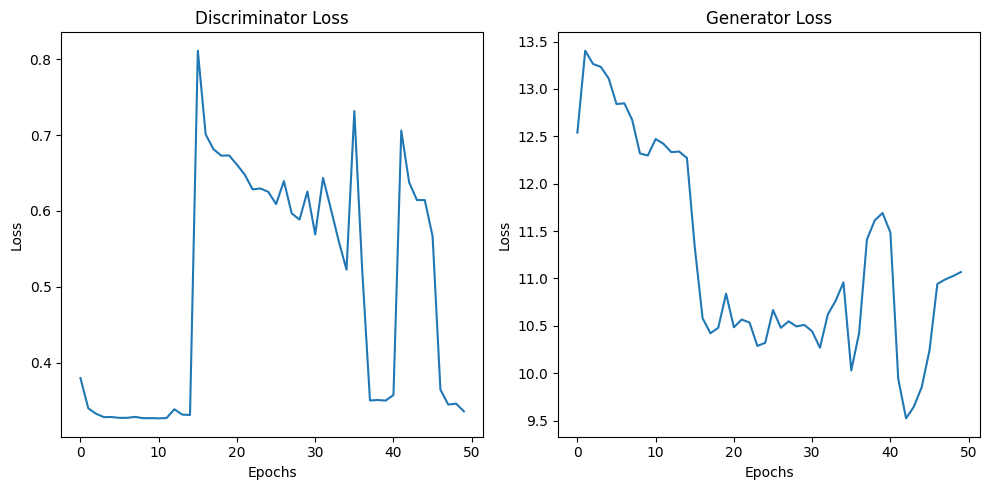

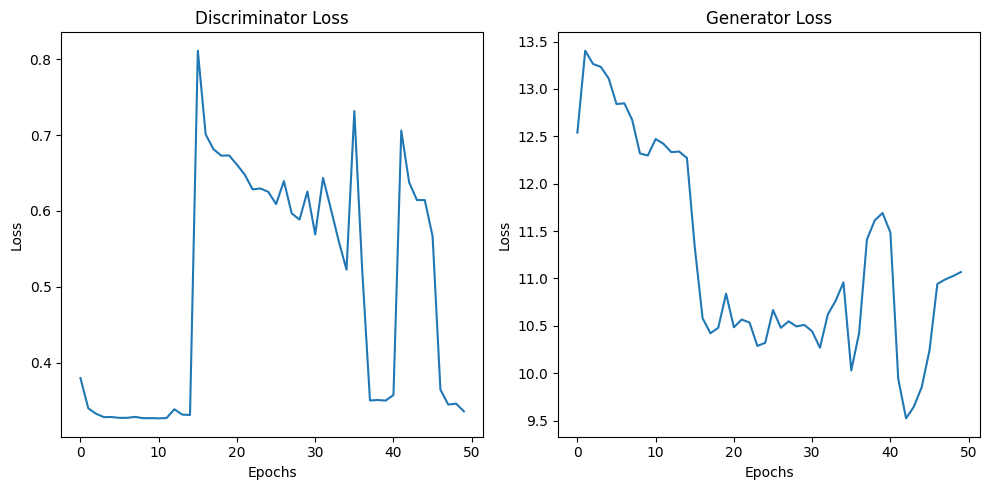


Best Parameters: lambda_L1=100, learning_rate=0.0002


In [22]:
best_params = hyperparameter_tuning(unet_generator, discriminator, dataloader, device, use_l1=True)

### Observations on U-Net Generator

There appears to be some sort of overfitting going on. considering, for all the 4 tuning models, the generated images were really close to the actual comic image. As for the best params lambda_L1=100, learning_rate=0.0002, I do think that the Generator Loss and the Discriminator

Loss have not converged just yet, but they do seem to be going in the right direction. This again, leads me to believe that it maybe over-fitting.###

### LightResNet Generator


Training with lambda_L1=100, learning_rate=0.0001


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.6015 Loss_G: 0.9912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99998707..0.9999377].


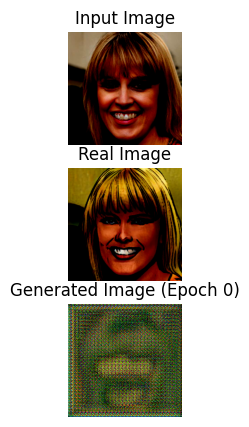

Training Epochs:   2%|▏         | 1/50 [00:24<20:24, 24.98s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.3427 Loss_G: 2.0085


Training Epochs:   4%|▍         | 2/50 [00:49<19:48, 24.75s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.3380 Loss_G: 2.0498


Training Epochs:   6%|▌         | 3/50 [01:14<19:20, 24.70s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.3383 Loss_G: 2.5663


Training Epochs:   8%|▊         | 4/50 [01:39<19:00, 24.78s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.3732 Loss_G: 2.0218


Training Epochs:  10%|█         | 5/50 [02:03<18:34, 24.76s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.3432 Loss_G: 1.8810


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999887..0.999998].


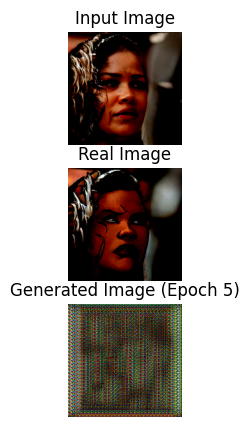

Training Epochs:  12%|█▏        | 6/50 [02:28<18:13, 24.84s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.3366 Loss_G: 2.3179


Training Epochs:  14%|█▍        | 7/50 [02:53<17:47, 24.82s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.3582 Loss_G: 2.9734


Training Epochs:  16%|█▌        | 8/50 [03:18<17:23, 24.83s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.3302 Loss_G: 2.1026


Training Epochs:  18%|█▊        | 9/50 [03:42<16:53, 24.71s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.3555 Loss_G: 2.1473


Training Epochs:  20%|██        | 10/50 [04:07<16:32, 24.81s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.3284 Loss_G: 2.1398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99962986..0.99988574].


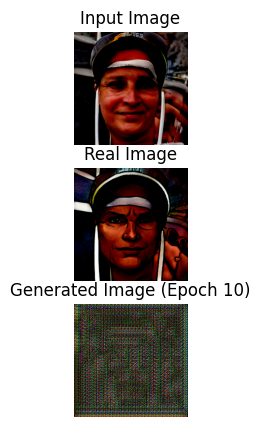

Training Epochs:  22%|██▏       | 11/50 [04:32<16:06, 24.78s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.3464 Loss_G: 2.0023


Training Epochs:  24%|██▍       | 12/50 [04:57<15:40, 24.75s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.3357 Loss_G: 1.9276


Training Epochs:  26%|██▌       | 13/50 [05:22<15:17, 24.80s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.3312 Loss_G: 2.2249


Training Epochs:  28%|██▊       | 14/50 [05:47<14:52, 24.79s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.3386 Loss_G: 2.1726


Training Epochs:  30%|███       | 15/50 [06:11<14:27, 24.77s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.3294 Loss_G: 2.1089


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


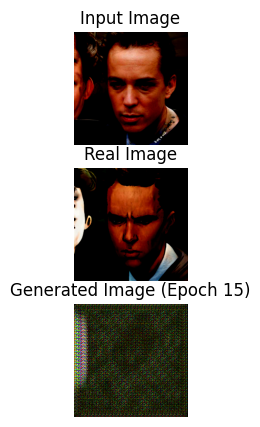

Training Epochs:  32%|███▏      | 16/50 [06:36<14:02, 24.78s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.3342 Loss_G: 2.1182


Training Epochs:  34%|███▍      | 17/50 [07:01<13:38, 24.81s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.3332 Loss_G: 2.5084


Training Epochs:  36%|███▌      | 18/50 [07:26<13:14, 24.83s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.3273 Loss_G: 2.0507


Training Epochs:  38%|███▊      | 19/50 [07:51<12:51, 24.88s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.3299 Loss_G: 2.1059


Training Epochs:  40%|████      | 20/50 [08:16<12:27, 24.91s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.3369 Loss_G: 2.2212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98809314..0.9667141].


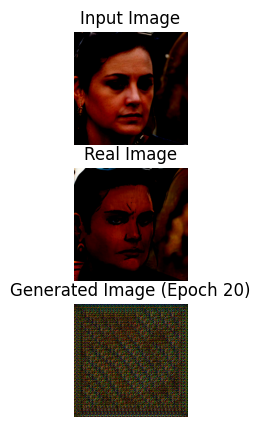

Training Epochs:  42%|████▏     | 21/50 [08:41<12:05, 25.02s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.3328 Loss_G: 2.2620


Training Epochs:  44%|████▍     | 22/50 [09:06<11:42, 25.10s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.3313 Loss_G: 2.0433


Training Epochs:  46%|████▌     | 23/50 [09:32<11:19, 25.17s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.3514 Loss_G: 2.1499


Training Epochs:  48%|████▊     | 24/50 [09:57<10:53, 25.15s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.3271 Loss_G: 2.0951


Training Epochs:  50%|█████     | 25/50 [10:22<10:28, 25.13s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.3298 Loss_G: 2.2573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.996393..0.9871411].


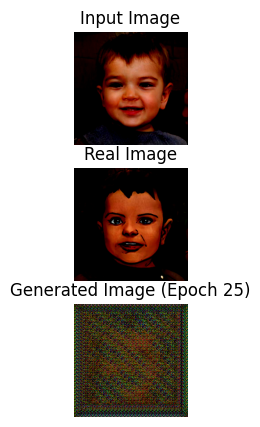

Training Epochs:  52%|█████▏    | 26/50 [10:47<10:03, 25.16s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.3298 Loss_G: 2.3209


Training Epochs:  54%|█████▍    | 27/50 [11:12<09:36, 25.05s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.3341 Loss_G: 2.0205


Training Epochs:  56%|█████▌    | 28/50 [11:37<09:09, 24.98s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.3347 Loss_G: 2.3612


Training Epochs:  58%|█████▊    | 29/50 [12:02<08:44, 24.98s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.3322 Loss_G: 1.9099


Training Epochs:  60%|██████    | 30/50 [12:27<08:18, 24.93s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.3415 Loss_G: 2.3422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99879086..0.98614156].


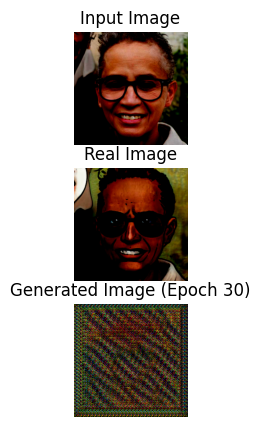

Training Epochs:  62%|██████▏   | 31/50 [12:51<07:53, 24.92s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.3265 Loss_G: 2.0895


Training Epochs:  64%|██████▍   | 32/50 [13:16<07:28, 24.89s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.3391 Loss_G: 2.1989


Training Epochs:  66%|██████▌   | 33/50 [13:41<07:03, 24.91s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.3352 Loss_G: 2.2095


Training Epochs:  68%|██████▊   | 34/50 [14:06<06:37, 24.86s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.3359 Loss_G: 2.5225


Training Epochs:  70%|███████   | 35/50 [14:31<06:11, 24.79s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.3297 Loss_G: 2.2307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


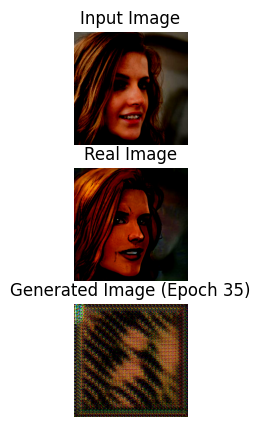

Training Epochs:  72%|███████▏  | 36/50 [14:55<05:47, 24.79s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.3515 Loss_G: 2.0632


Training Epochs:  74%|███████▍  | 37/50 [15:20<05:22, 24.77s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.3596 Loss_G: 2.4450


Training Epochs:  76%|███████▌  | 38/50 [15:45<04:57, 24.81s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.4965 Loss_G: 2.3833


Training Epochs:  78%|███████▊  | 39/50 [16:10<04:32, 24.79s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.4278 Loss_G: 1.7619


Training Epochs:  80%|████████  | 40/50 [16:35<04:08, 24.88s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.3353 Loss_G: 2.0308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99888355..0.80855936].


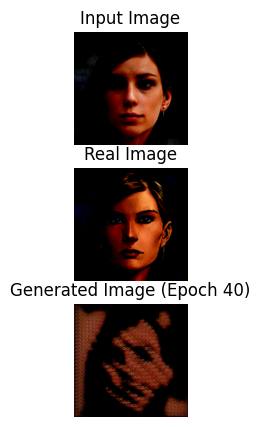

Training Epochs:  82%|████████▏ | 41/50 [17:00<03:43, 24.89s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.3307 Loss_G: 2.1728


Training Epochs:  84%|████████▍ | 42/50 [17:25<03:19, 24.91s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.3332 Loss_G: 2.2185


Training Epochs:  86%|████████▌ | 43/50 [17:50<02:54, 24.92s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.3354 Loss_G: 2.2645


Training Epochs:  88%|████████▊ | 44/50 [18:14<02:29, 24.90s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.3395 Loss_G: 2.2279


Training Epochs:  90%|█████████ | 45/50 [18:39<02:04, 24.88s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.3410 Loss_G: 2.1023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


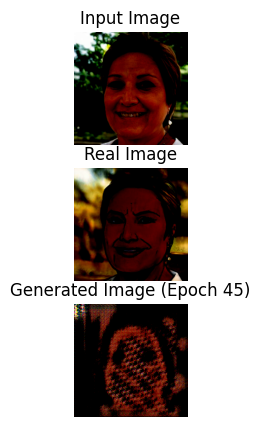

Training Epochs:  92%|█████████▏| 46/50 [19:04<01:39, 24.91s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.3415 Loss_G: 2.0332


Training Epochs:  94%|█████████▍| 47/50 [19:29<01:14, 24.89s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.3605 Loss_G: 2.1577


Training Epochs:  96%|█████████▌| 48/50 [19:54<00:49, 24.90s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.3345 Loss_G: 1.9449


Training Epochs:  98%|█████████▊| 49/50 [20:19<00:24, 24.78s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.3346 Loss_G: 2.3600


Training Epochs: 100%|██████████| 50/50 [20:43<00:00, 24.87s/it]


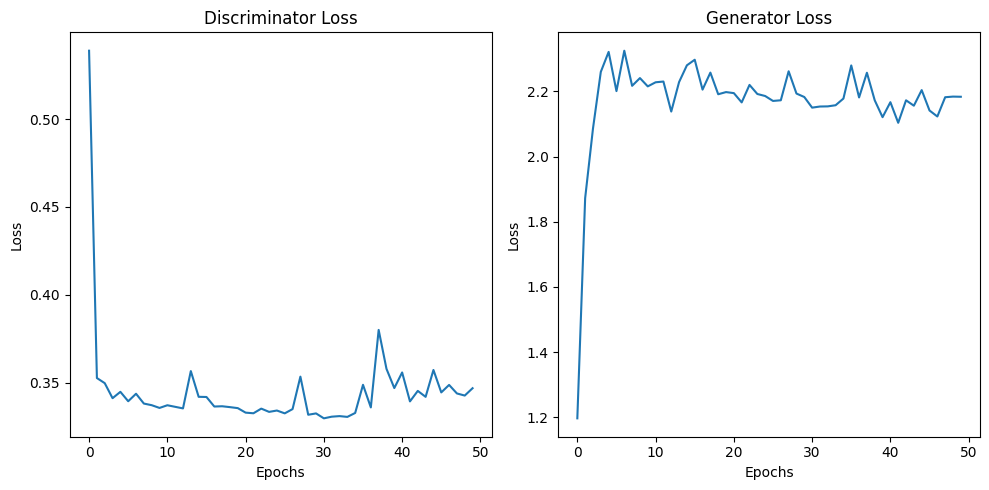

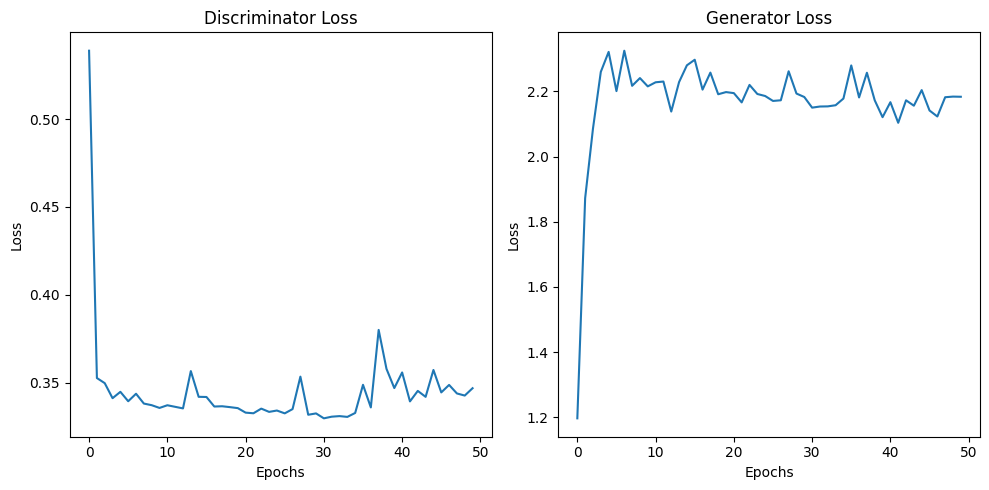


Training with lambda_L1=100, learning_rate=0.0002


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.3385 Loss_G: 3.2454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


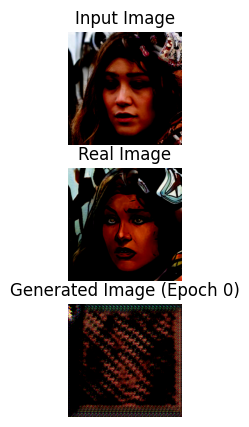

Training Epochs:   2%|▏         | 1/50 [00:24<20:04, 24.59s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.3390 Loss_G: 2.4291


Training Epochs:   4%|▍         | 2/50 [00:49<19:40, 24.60s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.3369 Loss_G: 2.1128


Training Epochs:   6%|▌         | 3/50 [01:13<19:13, 24.54s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.3645 Loss_G: 2.1064


Training Epochs:   8%|▊         | 4/50 [01:38<18:46, 24.48s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.3434 Loss_G: 2.2931


Training Epochs:  10%|█         | 5/50 [02:02<18:22, 24.50s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.7368 Loss_G: 1.3973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.995853].


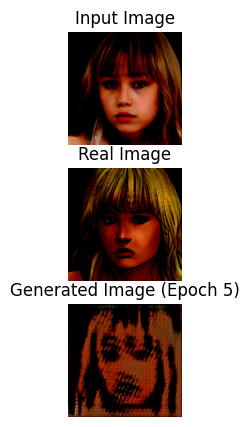

Training Epochs:  12%|█▏        | 6/50 [02:27<18:00, 24.56s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.3314 Loss_G: 2.0901


Training Epochs:  14%|█▍        | 7/50 [02:51<17:36, 24.56s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.3303 Loss_G: 1.8521


Training Epochs:  16%|█▌        | 8/50 [03:16<17:11, 24.55s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.4135 Loss_G: 1.9568


Training Epochs:  18%|█▊        | 9/50 [03:40<16:45, 24.52s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.4732 Loss_G: 2.1649


Training Epochs:  20%|██        | 10/50 [04:05<16:19, 24.48s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.3481 Loss_G: 2.3440


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.98513776].


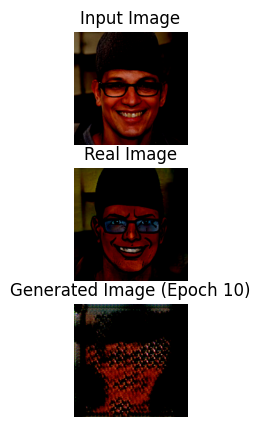

Training Epochs:  22%|██▏       | 11/50 [04:29<15:54, 24.48s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.3651 Loss_G: 2.9643


Training Epochs:  24%|██▍       | 12/50 [04:54<15:28, 24.44s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.3399 Loss_G: 2.0286


Training Epochs:  26%|██▌       | 13/50 [05:18<15:02, 24.39s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.3316 Loss_G: 1.9353


Training Epochs:  28%|██▊       | 14/50 [05:42<14:39, 24.42s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.3431 Loss_G: 2.6518


Training Epochs:  30%|███       | 15/50 [06:07<14:13, 24.40s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.4534 Loss_G: 1.1946


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999994..0.7946569].


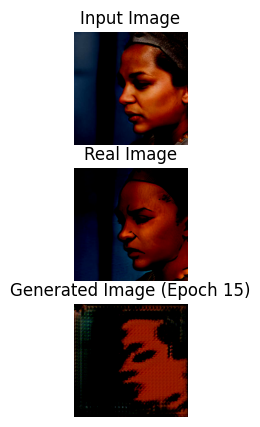

Training Epochs:  32%|███▏      | 16/50 [06:31<13:53, 24.51s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.3405 Loss_G: 2.0989


Training Epochs:  34%|███▍      | 17/50 [06:56<13:29, 24.54s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.3396 Loss_G: 1.9848


Training Epochs:  36%|███▌      | 18/50 [07:21<13:06, 24.56s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.3466 Loss_G: 1.6505


Training Epochs:  38%|███▊      | 19/50 [07:45<12:42, 24.58s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.3533 Loss_G: 2.1192


Training Epochs:  40%|████      | 20/50 [08:10<12:15, 24.52s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.3314 Loss_G: 2.1623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9684705].


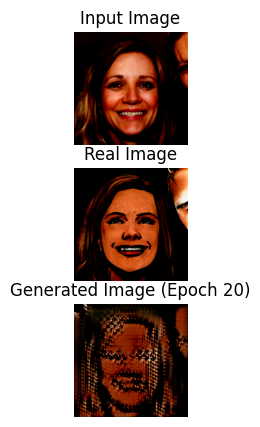

Training Epochs:  42%|████▏     | 21/50 [08:34<11:52, 24.57s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.3773 Loss_G: 1.8897


Training Epochs:  44%|████▍     | 22/50 [08:59<11:30, 24.66s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.3435 Loss_G: 1.8649


Training Epochs:  46%|████▌     | 23/50 [09:24<11:06, 24.69s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.3414 Loss_G: 1.5567


Training Epochs:  48%|████▊     | 24/50 [09:49<10:41, 24.67s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.3698 Loss_G: 2.0011


Training Epochs:  50%|█████     | 25/50 [10:13<10:16, 24.67s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.3433 Loss_G: 2.0802


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96600854].


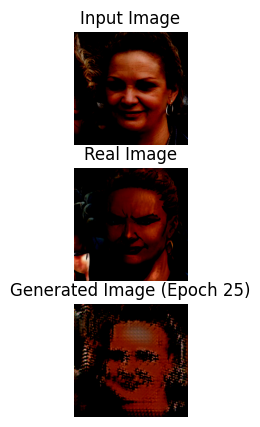

Training Epochs:  52%|█████▏    | 26/50 [10:38<09:53, 24.72s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.4693 Loss_G: 3.3988


Training Epochs:  54%|█████▍    | 27/50 [11:03<09:28, 24.73s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.3326 Loss_G: 2.0806


Training Epochs:  56%|█████▌    | 28/50 [11:28<09:05, 24.78s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.3468 Loss_G: 2.3157


Training Epochs:  58%|█████▊    | 29/50 [11:53<08:40, 24.80s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.3366 Loss_G: 2.4648


Training Epochs:  60%|██████    | 30/50 [12:17<08:16, 24.82s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.3510 Loss_G: 2.4960


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9152203].


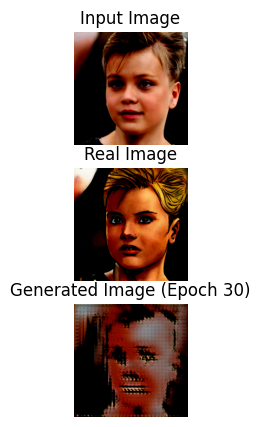

Training Epochs:  62%|██████▏   | 31/50 [12:42<07:51, 24.80s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.3383 Loss_G: 2.1348


Training Epochs:  64%|██████▍   | 32/50 [13:07<07:26, 24.79s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.3641 Loss_G: 2.9199


Training Epochs:  66%|██████▌   | 33/50 [13:32<07:01, 24.79s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.3869 Loss_G: 3.0285


Training Epochs:  68%|██████▊   | 34/50 [13:57<06:36, 24.81s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.5442 Loss_G: 1.2928


Training Epochs:  70%|███████   | 35/50 [14:21<06:11, 24.77s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.4565 Loss_G: 2.0299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.86225367].


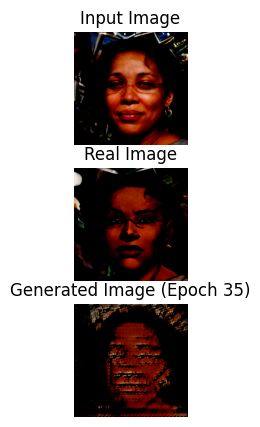

Training Epochs:  72%|███████▏  | 36/50 [14:46<05:47, 24.82s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.3729 Loss_G: 2.3351


Training Epochs:  74%|███████▍  | 37/50 [15:11<05:21, 24.77s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.3357 Loss_G: 1.6495


Training Epochs:  76%|███████▌  | 38/50 [15:36<04:56, 24.75s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.3300 Loss_G: 2.1656


Training Epochs:  78%|███████▊  | 39/50 [16:00<04:32, 24.74s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.3387 Loss_G: 2.3928


Training Epochs:  80%|████████  | 40/50 [16:25<04:07, 24.80s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.3386 Loss_G: 1.9420


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9172041].


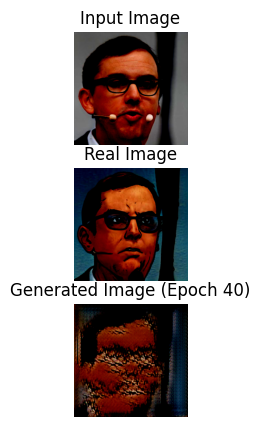

Training Epochs:  82%|████████▏ | 41/50 [16:50<03:43, 24.83s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.4018 Loss_G: 2.9060


Training Epochs:  84%|████████▍ | 42/50 [17:15<03:18, 24.83s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.3622 Loss_G: 2.2473


Training Epochs:  86%|████████▌ | 43/50 [17:40<02:53, 24.79s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.3538 Loss_G: 2.6067


Training Epochs:  88%|████████▊ | 44/50 [18:04<02:28, 24.79s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.6770 Loss_G: 3.7931


Training Epochs:  90%|█████████ | 45/50 [18:29<02:04, 24.85s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.3619 Loss_G: 1.9974


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9562674].


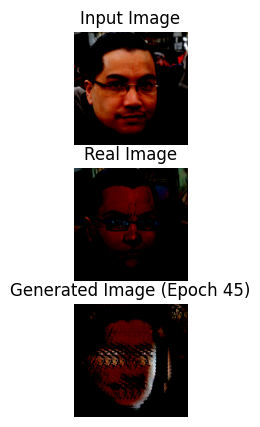

Training Epochs:  92%|█████████▏| 46/50 [18:54<01:39, 24.84s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.3845 Loss_G: 2.2910


Training Epochs:  94%|█████████▍| 47/50 [19:19<01:14, 24.83s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.3567 Loss_G: 2.2589


Training Epochs:  96%|█████████▌| 48/50 [19:44<00:49, 24.84s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.3424 Loss_G: 2.0957


Training Epochs:  98%|█████████▊| 49/50 [20:09<00:24, 24.82s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.3446 Loss_G: 2.0438


Training Epochs: 100%|██████████| 50/50 [20:33<00:00, 24.68s/it]


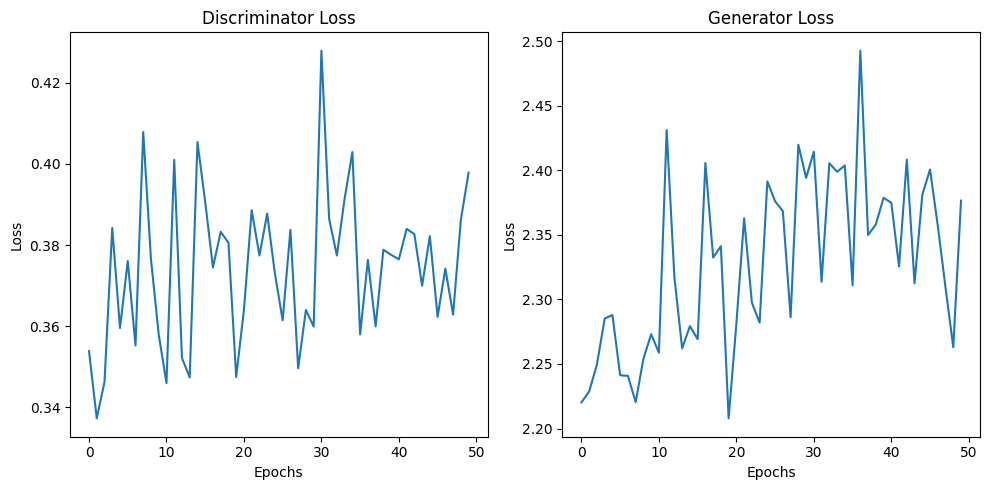

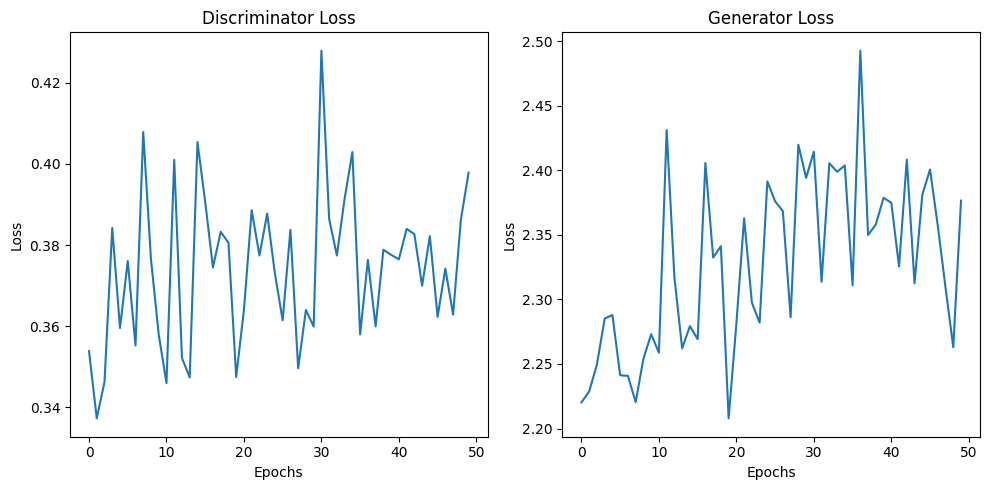


Training with lambda_L1=200, learning_rate=0.0001


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.3911 Loss_G: 2.3858


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9953864..0.9484553].


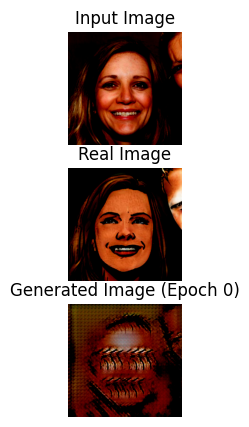

Training Epochs:   2%|▏         | 1/50 [00:24<19:57, 24.43s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.3514 Loss_G: 2.1745


Training Epochs:   4%|▍         | 2/50 [00:48<19:30, 24.38s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.3363 Loss_G: 1.9260


Training Epochs:   6%|▌         | 3/50 [01:13<19:09, 24.45s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.4278 Loss_G: 3.0475


Training Epochs:   8%|▊         | 4/50 [01:37<18:47, 24.52s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.3405 Loss_G: 1.9871


Training Epochs:  10%|█         | 5/50 [02:02<18:22, 24.49s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.3624 Loss_G: 2.6201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.95041376].


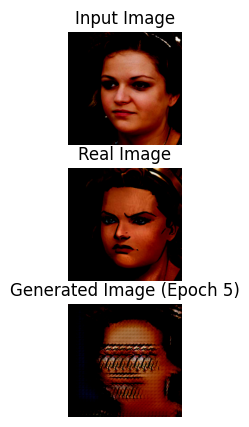

Training Epochs:  12%|█▏        | 6/50 [02:27<18:02, 24.60s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.3442 Loss_G: 2.4346


Training Epochs:  14%|█▍        | 7/50 [02:51<17:40, 24.67s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.3577 Loss_G: 2.5789


Training Epochs:  16%|█▌        | 8/50 [03:16<17:16, 24.67s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.3417 Loss_G: 2.5127


Training Epochs:  18%|█▊        | 9/50 [03:41<16:50, 24.64s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.3392 Loss_G: 2.0620


Training Epochs:  20%|██        | 10/50 [04:05<16:23, 24.59s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.3829 Loss_G: 2.2465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.999995..0.95247].


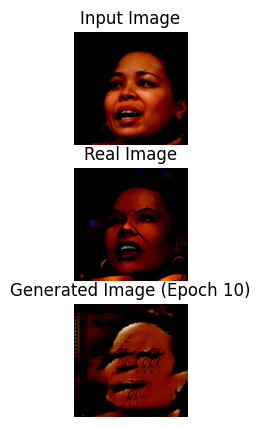

Training Epochs:  22%|██▏       | 11/50 [04:30<16:00, 24.64s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.4673 Loss_G: 2.7682


Training Epochs:  24%|██▍       | 12/50 [04:55<15:35, 24.62s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.4165 Loss_G: 2.6677


Training Epochs:  26%|██▌       | 13/50 [05:19<15:09, 24.59s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.3677 Loss_G: 2.1033


Training Epochs:  28%|██▊       | 14/50 [05:44<14:44, 24.56s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.4098 Loss_G: 2.5960


Training Epochs:  30%|███       | 15/50 [06:08<14:21, 24.62s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.3387 Loss_G: 2.3551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.921285].


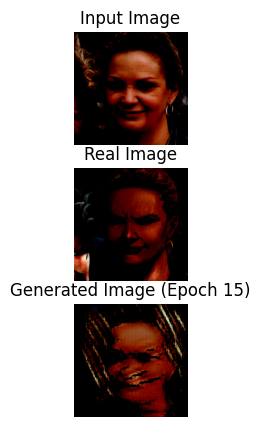

Training Epochs:  32%|███▏      | 16/50 [06:33<13:55, 24.57s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.3842 Loss_G: 2.9172


Training Epochs:  34%|███▍      | 17/50 [06:57<13:30, 24.56s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.5447 Loss_G: 4.2541


Training Epochs:  36%|███▌      | 18/50 [07:22<13:05, 24.56s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.3332 Loss_G: 2.0943


Training Epochs:  38%|███▊      | 19/50 [07:46<12:39, 24.50s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.3325 Loss_G: 2.5529


Training Epochs:  40%|████      | 20/50 [08:11<12:14, 24.49s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.3618 Loss_G: 2.5503


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.87730014].


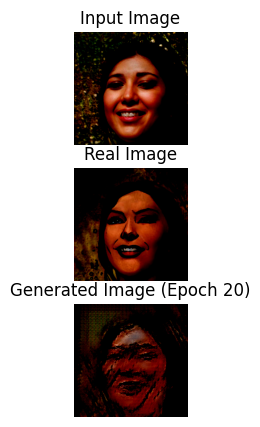

Training Epochs:  42%|████▏     | 21/50 [08:35<11:50, 24.52s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.3761 Loss_G: 2.1818


Training Epochs:  44%|████▍     | 22/50 [09:00<11:24, 24.46s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.3480 Loss_G: 2.7925


Training Epochs:  46%|████▌     | 23/50 [09:24<11:00, 24.45s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.3408 Loss_G: 1.9215


Training Epochs:  48%|████▊     | 24/50 [09:48<10:35, 24.42s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.3563 Loss_G: 2.4327


Training Epochs:  50%|█████     | 25/50 [10:13<10:12, 24.49s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.3512 Loss_G: 2.2991


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999997..0.91396344].


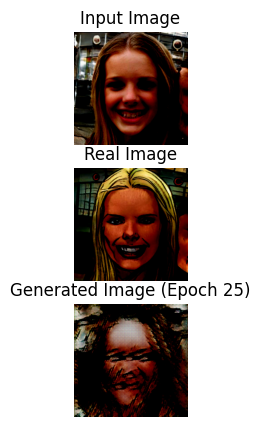

Training Epochs:  52%|█████▏    | 26/50 [10:38<09:49, 24.56s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.3399 Loss_G: 2.5487


Training Epochs:  54%|█████▍    | 27/50 [11:02<09:23, 24.52s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.3458 Loss_G: 2.0071


Training Epochs:  56%|█████▌    | 28/50 [11:27<09:00, 24.57s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.3729 Loss_G: 2.0513


Training Epochs:  58%|█████▊    | 29/50 [11:52<08:37, 24.63s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.3705 Loss_G: 1.4119


Training Epochs:  60%|██████    | 30/50 [12:17<08:14, 24.72s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.3925 Loss_G: 2.7956


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9954143].


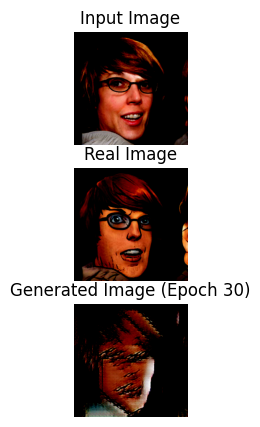

Training Epochs:  62%|██████▏   | 31/50 [12:41<07:49, 24.71s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.3671 Loss_G: 2.6632


Training Epochs:  64%|██████▍   | 32/50 [13:06<07:25, 24.75s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.3458 Loss_G: 2.3404


Training Epochs:  66%|██████▌   | 33/50 [13:31<07:00, 24.75s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.3324 Loss_G: 2.3502


Training Epochs:  68%|██████▊   | 34/50 [13:55<06:34, 24.68s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.3410 Loss_G: 2.2879


Training Epochs:  70%|███████   | 35/50 [14:20<06:10, 24.71s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.3873 Loss_G: 2.8628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999596..0.974766].


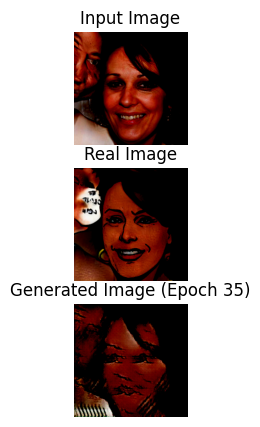

Training Epochs:  72%|███████▏  | 36/50 [14:45<05:45, 24.65s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.3574 Loss_G: 2.1101


Training Epochs:  74%|███████▍  | 37/50 [15:09<05:20, 24.64s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.3520 Loss_G: 1.8086


Training Epochs:  76%|███████▌  | 38/50 [15:34<04:56, 24.67s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.3690 Loss_G: 2.3481


Training Epochs:  78%|███████▊  | 39/50 [15:59<04:31, 24.64s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.3387 Loss_G: 2.5115


Training Epochs:  80%|████████  | 40/50 [16:24<04:07, 24.73s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.3834 Loss_G: 3.2039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999999..0.9655002].


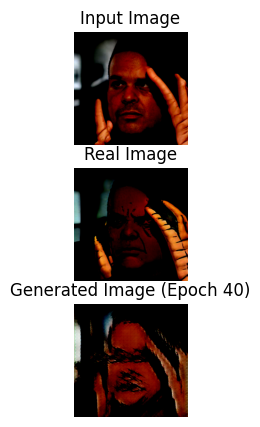

Training Epochs:  82%|████████▏ | 41/50 [16:48<03:43, 24.79s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.3428 Loss_G: 2.5023


Training Epochs:  84%|████████▍ | 42/50 [17:13<03:17, 24.70s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.3555 Loss_G: 2.0872


Training Epochs:  86%|████████▌ | 43/50 [17:37<02:52, 24.62s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.3682 Loss_G: 2.3665


Training Epochs:  88%|████████▊ | 44/50 [18:02<02:27, 24.62s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.4318 Loss_G: 1.1079


Training Epochs:  90%|█████████ | 45/50 [18:27<02:03, 24.64s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.3422 Loss_G: 2.1298


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9866262].


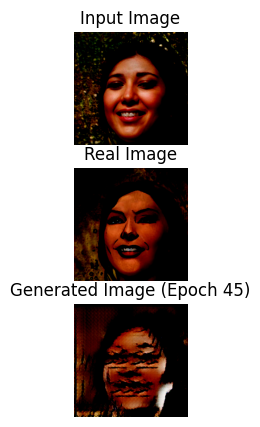

Training Epochs:  92%|█████████▏| 46/50 [18:52<01:38, 24.71s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.3860 Loss_G: 2.6391


Training Epochs:  94%|█████████▍| 47/50 [19:16<01:13, 24.66s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.3975 Loss_G: 1.9235


Training Epochs:  96%|█████████▌| 48/50 [19:41<00:49, 24.65s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.3541 Loss_G: 2.4118


Training Epochs:  98%|█████████▊| 49/50 [20:05<00:24, 24.66s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.3654 Loss_G: 1.8539


Training Epochs: 100%|██████████| 50/50 [20:30<00:00, 24.61s/it]


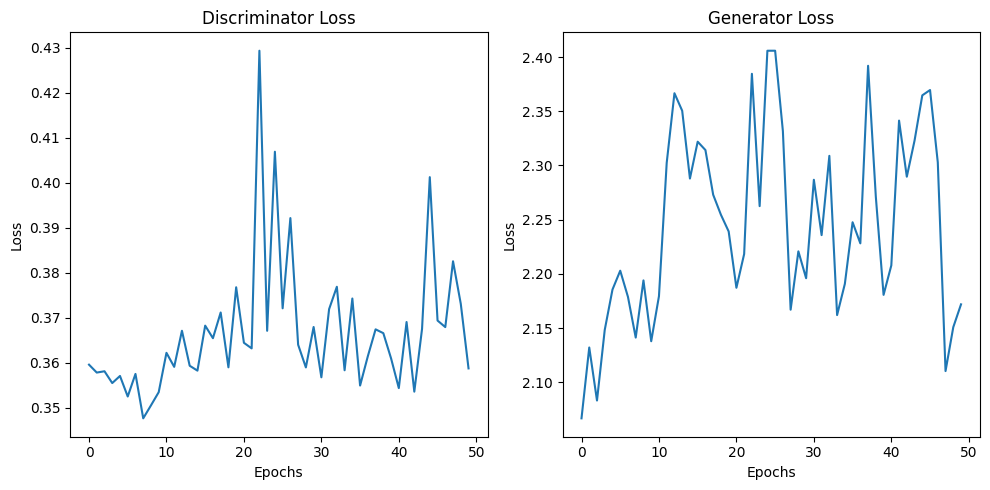

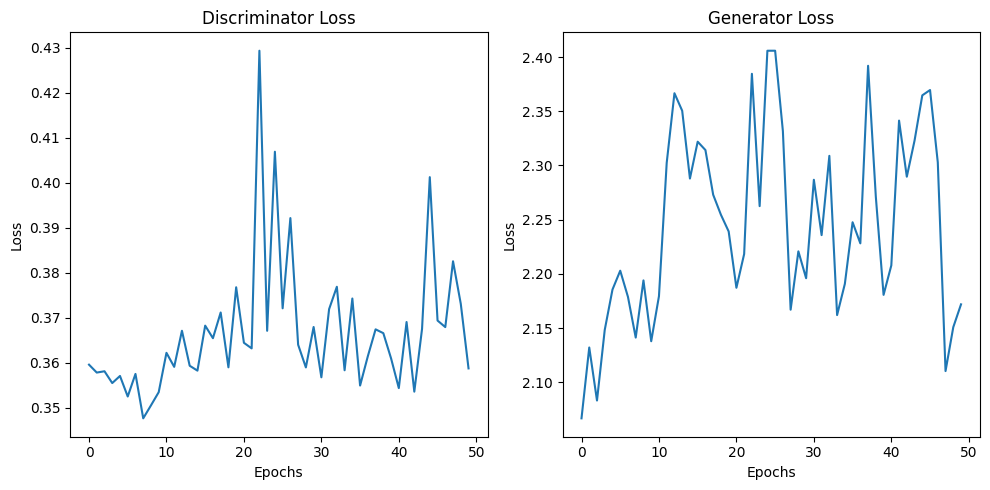


Training with lambda_L1=200, learning_rate=0.0002


Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch 0/25 Loss_D: 0.3487 Loss_G: 0.4646


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.93334275].


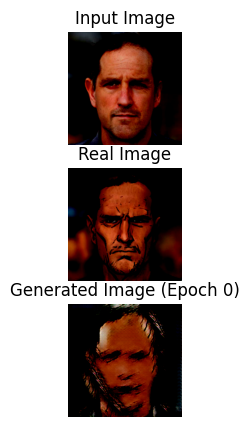

Training Epochs:   2%|▏         | 1/50 [00:24<19:44, 24.18s/it]

Epoch 1/50 Batch 0/25 Loss_D: 0.3524 Loss_G: 2.5813


Training Epochs:   4%|▍         | 2/50 [00:48<19:20, 24.18s/it]

Epoch 2/50 Batch 0/25 Loss_D: 0.3408 Loss_G: 1.5693


Training Epochs:   6%|▌         | 3/50 [01:12<18:56, 24.17s/it]

Epoch 3/50 Batch 0/25 Loss_D: 0.3531 Loss_G: 1.8446


Training Epochs:   8%|▊         | 4/50 [01:36<18:33, 24.20s/it]

Epoch 4/50 Batch 0/25 Loss_D: 0.3417 Loss_G: 2.3410


Training Epochs:  10%|█         | 5/50 [02:00<18:08, 24.19s/it]

Epoch 5/50 Batch 0/25 Loss_D: 0.4004 Loss_G: 2.3742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999898..0.8714645].


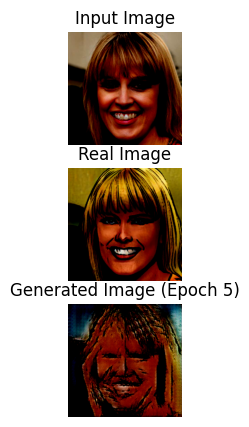

Training Epochs:  12%|█▏        | 6/50 [02:25<17:49, 24.30s/it]

Epoch 6/50 Batch 0/25 Loss_D: 0.3964 Loss_G: 2.0150


Training Epochs:  14%|█▍        | 7/50 [02:49<17:26, 24.33s/it]

Epoch 7/50 Batch 0/25 Loss_D: 0.3336 Loss_G: 2.2526


Training Epochs:  16%|█▌        | 8/50 [03:14<17:01, 24.33s/it]

Epoch 8/50 Batch 0/25 Loss_D: 0.3779 Loss_G: 2.4359


Training Epochs:  18%|█▊        | 9/50 [03:38<16:38, 24.35s/it]

Epoch 9/50 Batch 0/25 Loss_D: 0.3706 Loss_G: 2.1268


Training Epochs:  20%|██        | 10/50 [04:02<16:13, 24.34s/it]

Epoch 10/50 Batch 0/25 Loss_D: 0.6291 Loss_G: 3.9418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99929786..0.964283].


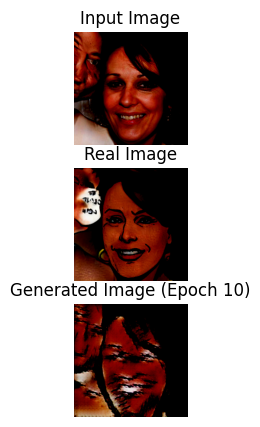

Training Epochs:  22%|██▏       | 11/50 [04:27<15:47, 24.30s/it]

Epoch 11/50 Batch 0/25 Loss_D: 0.3690 Loss_G: 2.2098


Training Epochs:  24%|██▍       | 12/50 [04:51<15:21, 24.26s/it]

Epoch 12/50 Batch 0/25 Loss_D: 0.3568 Loss_G: 2.3202


Training Epochs:  26%|██▌       | 13/50 [05:15<14:59, 24.32s/it]

Epoch 13/50 Batch 0/25 Loss_D: 0.4299 Loss_G: 1.8771


Training Epochs:  28%|██▊       | 14/50 [05:40<14:37, 24.37s/it]

Epoch 14/50 Batch 0/25 Loss_D: 0.3517 Loss_G: 2.1077


Training Epochs:  30%|███       | 15/50 [06:04<14:10, 24.31s/it]

Epoch 15/50 Batch 0/25 Loss_D: 0.4867 Loss_G: 2.4348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7121425].


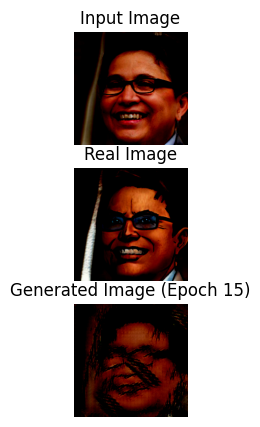

Training Epochs:  32%|███▏      | 16/50 [06:28<13:49, 24.39s/it]

Epoch 16/50 Batch 0/25 Loss_D: 0.3485 Loss_G: 3.1401


Training Epochs:  34%|███▍      | 17/50 [06:53<13:25, 24.41s/it]

Epoch 17/50 Batch 0/25 Loss_D: 0.4009 Loss_G: 2.7403


Training Epochs:  36%|███▌      | 18/50 [07:17<13:01, 24.43s/it]

Epoch 18/50 Batch 0/25 Loss_D: 0.3573 Loss_G: 2.7451


Training Epochs:  38%|███▊      | 19/50 [07:42<12:37, 24.43s/it]

Epoch 19/50 Batch 0/25 Loss_D: 0.3658 Loss_G: 2.8998


Training Epochs:  40%|████      | 20/50 [08:06<12:15, 24.50s/it]

Epoch 20/50 Batch 0/25 Loss_D: 0.3570 Loss_G: 2.8963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99803865..0.69000876].


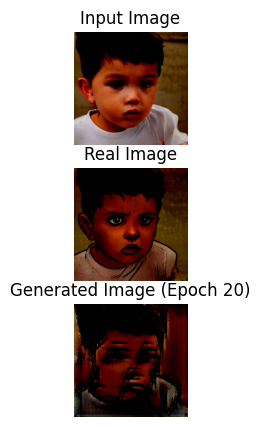

Training Epochs:  42%|████▏     | 21/50 [08:31<11:50, 24.50s/it]

Epoch 21/50 Batch 0/25 Loss_D: 0.3398 Loss_G: 2.3993


Training Epochs:  44%|████▍     | 22/50 [08:55<11:25, 24.48s/it]

Epoch 22/50 Batch 0/25 Loss_D: 0.3477 Loss_G: 2.5774


Training Epochs:  46%|████▌     | 23/50 [09:20<11:02, 24.53s/it]

Epoch 23/50 Batch 0/25 Loss_D: 0.3667 Loss_G: 2.3387


Training Epochs:  48%|████▊     | 24/50 [09:45<10:38, 24.55s/it]

Epoch 24/50 Batch 0/25 Loss_D: 0.3979 Loss_G: 2.3561


Training Epochs:  50%|█████     | 25/50 [10:09<10:12, 24.52s/it]

Epoch 25/50 Batch 0/25 Loss_D: 0.4239 Loss_G: 2.7369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9995539..0.7824175].


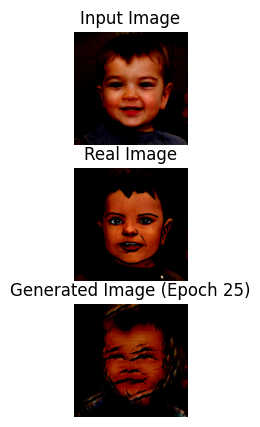

Training Epochs:  52%|█████▏    | 26/50 [10:34<09:48, 24.52s/it]

Epoch 26/50 Batch 0/25 Loss_D: 0.3679 Loss_G: 1.3813


Training Epochs:  54%|█████▍    | 27/50 [10:58<09:23, 24.49s/it]

Epoch 27/50 Batch 0/25 Loss_D: 0.4075 Loss_G: 3.5420


Training Epochs:  56%|█████▌    | 28/50 [11:22<08:58, 24.47s/it]

Epoch 28/50 Batch 0/25 Loss_D: 0.6234 Loss_G: 3.4778


Training Epochs:  58%|█████▊    | 29/50 [11:47<08:34, 24.49s/it]

Epoch 29/50 Batch 0/25 Loss_D: 0.3387 Loss_G: 2.2635


Training Epochs:  60%|██████    | 30/50 [12:12<08:10, 24.53s/it]

Epoch 30/50 Batch 0/25 Loss_D: 0.4058 Loss_G: 2.1782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.999998..0.86527634].


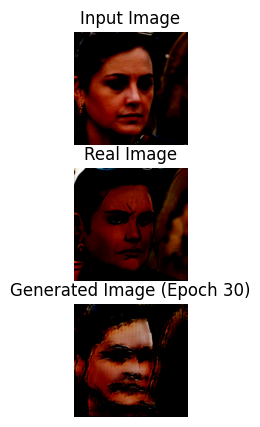

Training Epochs:  62%|██████▏   | 31/50 [12:36<07:46, 24.56s/it]

Epoch 31/50 Batch 0/25 Loss_D: 0.3946 Loss_G: 2.1073


Training Epochs:  64%|██████▍   | 32/50 [13:01<07:22, 24.56s/it]

Epoch 32/50 Batch 0/25 Loss_D: 0.3662 Loss_G: 1.8843


Training Epochs:  66%|██████▌   | 33/50 [13:25<06:57, 24.54s/it]

Epoch 33/50 Batch 0/25 Loss_D: 0.3384 Loss_G: 2.1309


Training Epochs:  68%|██████▊   | 34/50 [13:50<06:31, 24.48s/it]

Epoch 34/50 Batch 0/25 Loss_D: 0.3971 Loss_G: 2.4504


Training Epochs:  70%|███████   | 35/50 [14:14<06:06, 24.43s/it]

Epoch 35/50 Batch 0/25 Loss_D: 0.3467 Loss_G: 2.5609


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.91244614].


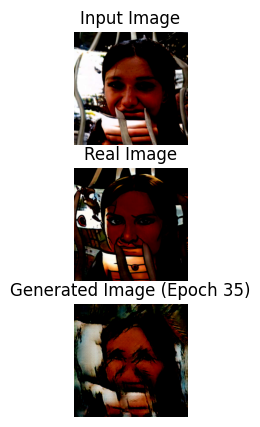

Training Epochs:  72%|███████▏  | 36/50 [14:38<05:42, 24.46s/it]

Epoch 36/50 Batch 0/25 Loss_D: 0.4416 Loss_G: 3.0291


Training Epochs:  74%|███████▍  | 37/50 [15:03<05:18, 24.47s/it]

Epoch 37/50 Batch 0/25 Loss_D: 0.3940 Loss_G: 2.2448


Training Epochs:  76%|███████▌  | 38/50 [15:28<04:54, 24.53s/it]

Epoch 38/50 Batch 0/25 Loss_D: 0.3919 Loss_G: 2.4176


Training Epochs:  78%|███████▊  | 39/50 [15:52<04:30, 24.55s/it]

Epoch 39/50 Batch 0/25 Loss_D: 0.3357 Loss_G: 1.9837


Training Epochs:  80%|████████  | 40/50 [16:17<04:04, 24.50s/it]

Epoch 40/50 Batch 0/25 Loss_D: 0.3526 Loss_G: 2.7454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998953..0.74269295].


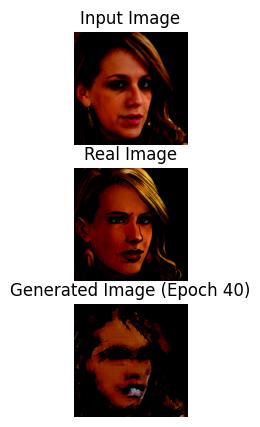

Training Epochs:  82%|████████▏ | 41/50 [16:41<03:40, 24.50s/it]

Epoch 41/50 Batch 0/25 Loss_D: 0.4267 Loss_G: 2.4447


Training Epochs:  84%|████████▍ | 42/50 [17:06<03:16, 24.51s/it]

Epoch 42/50 Batch 0/25 Loss_D: 0.3883 Loss_G: 2.5275


Training Epochs:  86%|████████▌ | 43/50 [17:30<02:51, 24.47s/it]

Epoch 43/50 Batch 0/25 Loss_D: 0.7190 Loss_G: 1.1956


Training Epochs:  88%|████████▊ | 44/50 [17:54<02:26, 24.46s/it]

Epoch 44/50 Batch 0/25 Loss_D: 0.3557 Loss_G: 1.9357


Training Epochs:  90%|█████████ | 45/50 [18:19<02:02, 24.44s/it]

Epoch 45/50 Batch 0/25 Loss_D: 0.3419 Loss_G: 2.3122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.73055345].


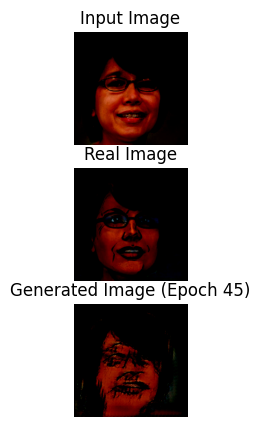

Training Epochs:  92%|█████████▏| 46/50 [18:43<01:37, 24.39s/it]

Epoch 46/50 Batch 0/25 Loss_D: 0.3504 Loss_G: 2.2160


Training Epochs:  94%|█████████▍| 47/50 [19:07<01:13, 24.36s/it]

Epoch 47/50 Batch 0/25 Loss_D: 0.3470 Loss_G: 1.6786


Training Epochs:  96%|█████████▌| 48/50 [19:32<00:48, 24.33s/it]

Epoch 48/50 Batch 0/25 Loss_D: 0.4003 Loss_G: 2.4928


Training Epochs:  98%|█████████▊| 49/50 [19:56<00:24, 24.35s/it]

Epoch 49/50 Batch 0/25 Loss_D: 0.3749 Loss_G: 1.3744


Training Epochs: 100%|██████████| 50/50 [20:20<00:00, 24.42s/it]


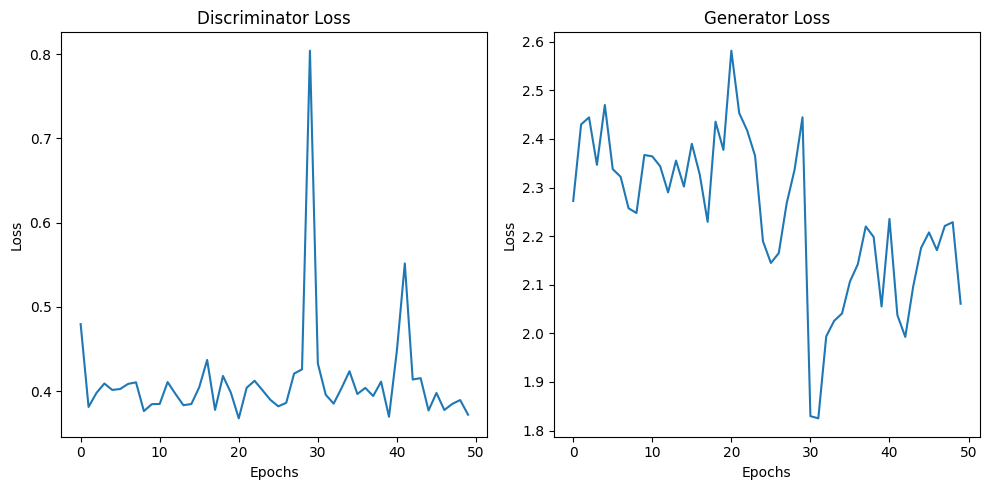

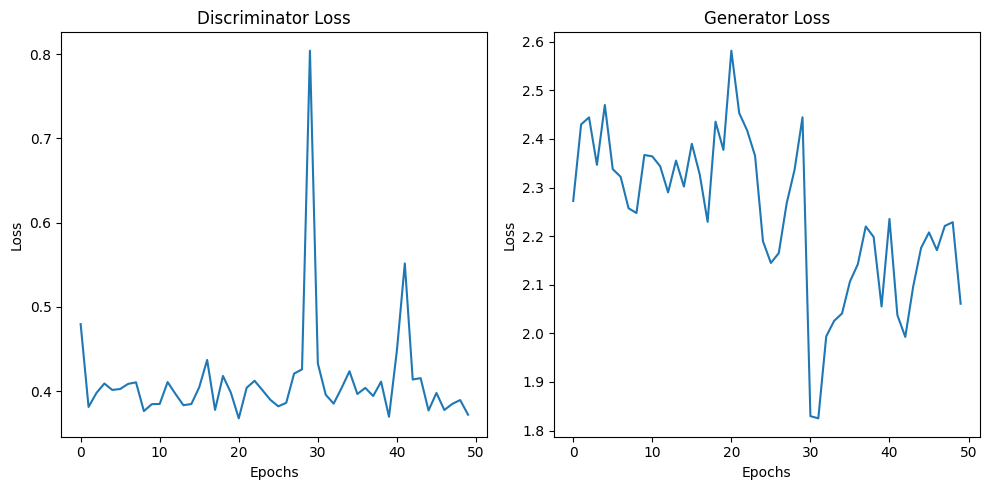


Best Parameters: lambda_L1=200, learning_rate=0.0002


In [23]:
best_params = hyperparameter_tuning(lightresnet_generator, discriminator, dataloader, device, use_l1=False)

### Observations

We can see that the LightResNet is not doing as good a job as the U-Net.

Ithink that, all the models between both generator architecures, could have been trained for more than 50 epochs, which would have allowed time to the models to get better.

So, what we will do is, we will train our final model using the best params, which is the U-Net generator Architecture, using lambda_L1=100, learning_rate=0.0002. But this time, we will train this over 100 epochs, and check it out.

# Final Model Training

In [24]:

final_generator = UNetGenerator().to(device)
final_discriminator = PatchGANDiscriminator().to(device)

lambda_L1 = 100
learning_rate = 2e-4
num_epochs = 100

In [25]:
def plot_loss_curves(loss_D_list, loss_G_list):
    epochs = range(len(loss_D_list))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_D_list, label="Discriminator Loss")
    plt.plot(epochs, loss_G_list, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.title("Training Loss Curves")
    plt.show()

In [26]:

def predict_and_visualize(model, input_path):
    model.eval()

    image = Image.open(input_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)

    output_image = output.squeeze(0).cpu()
    output_image = (output_image * 0.5) + 0.5 
    output_image = T.ToPILImage()(output_image)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Face")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title("Generated Comic")
    plt.show()

In [27]:

adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

optimizer_G = optim.Adam(final_generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(final_discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

loss_G_list = []
loss_D_list = []

In [28]:
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    final_generator.train()
    final_discriminator.train()

    epoch_loss_G = 0
    epoch_loss_D = 0

    for batch in dataloader:
        real_face = batch['face'].to(device)
        real_comic = batch['comic'].to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        fake_comic = final_generator(real_face)

        real_pred = discriminator(real_face, real_comic)
        fake_pred = discriminator(real_face, fake_comic.detach())

        valid = torch.ones_like(real_pred)
        fake = torch.zeros_like(fake_pred)

        loss_real = adversarial_loss(real_pred, valid)
        loss_fake = adversarial_loss(fake_pred, fake)
        loss_D = (loss_real + loss_fake) * 0.5

        loss_D.backward()
        optimizer_D.step()

        # ------------------
        #  Train Gennerator
        # ------------------
        optimizer_G.zero_grad()

        fake_pred = discriminator(real_face, fake_comic)
        gan_loss = adversarial_loss(fake_pred, valid)
        l1 = l1_loss(fake_comic, real_comic) * lambda_L1

        loss_G = gan_loss + l1
        loss_G.backward()
        optimizer_G.step()

        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()

    loss_G_list.append(epoch_loss_G / len(dataloader))
    loss_D_list.append(epoch_loss_D / len(dataloader))

    print(f"Epoch {epoch+1}/{num_epochs} – Loss_D: {loss_D_list[-1]:.4f}, Loss_G: {loss_G_list[-1]:.4f}")


Training Epochs:   1%|          | 1/100 [00:23<39:12, 23.77s/it]

Epoch 1/100 – Loss_D: 0.0512, Loss_G: 41.4171


Training Epochs:   2%|▏         | 2/100 [00:47<38:49, 23.77s/it]

Epoch 2/100 – Loss_D: 0.1011, Loss_G: 29.6164


Training Epochs:   3%|▎         | 3/100 [01:11<38:28, 23.80s/it]

Epoch 3/100 – Loss_D: 0.3873, Loss_G: 26.5124


Training Epochs:   4%|▍         | 4/100 [01:35<38:02, 23.78s/it]

Epoch 4/100 – Loss_D: 0.7257, Loss_G: 24.8563


Training Epochs:   5%|▌         | 5/100 [01:58<37:40, 23.79s/it]

Epoch 5/100 – Loss_D: 0.9920, Loss_G: 23.9974


Training Epochs:   6%|▌         | 6/100 [02:22<37:17, 23.80s/it]

Epoch 6/100 – Loss_D: 1.2091, Loss_G: 23.2309


Training Epochs:   7%|▋         | 7/100 [02:46<36:55, 23.82s/it]

Epoch 7/100 – Loss_D: 1.1965, Loss_G: 22.9936


Training Epochs:   8%|▊         | 8/100 [03:10<36:41, 23.93s/it]

Epoch 8/100 – Loss_D: 1.3774, Loss_G: 22.7562


Training Epochs:   9%|▉         | 9/100 [03:34<36:20, 23.97s/it]

Epoch 9/100 – Loss_D: 1.3635, Loss_G: 22.5572


Training Epochs:  10%|█         | 10/100 [03:58<35:50, 23.89s/it]

Epoch 10/100 – Loss_D: 1.4729, Loss_G: 22.3015


Training Epochs:  11%|█         | 11/100 [04:22<35:31, 23.95s/it]

Epoch 11/100 – Loss_D: 1.4062, Loss_G: 22.2632


Training Epochs:  12%|█▏        | 12/100 [04:46<35:03, 23.90s/it]

Epoch 12/100 – Loss_D: 1.4202, Loss_G: 22.0214


Training Epochs:  13%|█▎        | 13/100 [05:10<34:38, 23.89s/it]

Epoch 13/100 – Loss_D: 1.4532, Loss_G: 21.9279


Training Epochs:  14%|█▍        | 14/100 [05:34<34:14, 23.88s/it]

Epoch 14/100 – Loss_D: 1.4216, Loss_G: 22.0949


Training Epochs:  15%|█▌        | 15/100 [05:57<33:49, 23.87s/it]

Epoch 15/100 – Loss_D: 1.5070, Loss_G: 21.5691


Training Epochs:  16%|█▌        | 16/100 [06:21<33:27, 23.90s/it]

Epoch 16/100 – Loss_D: 1.4341, Loss_G: 21.7440


Training Epochs:  17%|█▋        | 17/100 [06:45<32:57, 23.83s/it]

Epoch 17/100 – Loss_D: 1.5752, Loss_G: 21.5193


Training Epochs:  18%|█▊        | 18/100 [07:09<32:35, 23.85s/it]

Epoch 18/100 – Loss_D: 1.4573, Loss_G: 21.3177


Training Epochs:  19%|█▉        | 19/100 [07:33<32:20, 23.95s/it]

Epoch 19/100 – Loss_D: 1.5104, Loss_G: 21.0850


Training Epochs:  20%|██        | 20/100 [07:57<32:02, 24.03s/it]

Epoch 20/100 – Loss_D: 1.5072, Loss_G: 20.9239


Training Epochs:  21%|██        | 21/100 [08:21<31:38, 24.04s/it]

Epoch 21/100 – Loss_D: 1.5204, Loss_G: 20.8616


Training Epochs:  22%|██▏       | 22/100 [08:46<31:17, 24.07s/it]

Epoch 22/100 – Loss_D: 1.4911, Loss_G: 20.2448


Training Epochs:  23%|██▎       | 23/100 [09:10<30:53, 24.08s/it]

Epoch 23/100 – Loss_D: 1.4925, Loss_G: 20.0943


Training Epochs:  24%|██▍       | 24/100 [09:34<30:27, 24.05s/it]

Epoch 24/100 – Loss_D: 1.4998, Loss_G: 19.7463


Training Epochs:  25%|██▌       | 25/100 [09:58<30:02, 24.03s/it]

Epoch 25/100 – Loss_D: 1.5343, Loss_G: 19.3475


Training Epochs:  26%|██▌       | 26/100 [10:22<29:39, 24.05s/it]

Epoch 26/100 – Loss_D: 1.5013, Loss_G: 19.2643


Training Epochs:  27%|██▋       | 27/100 [10:46<29:16, 24.06s/it]

Epoch 27/100 – Loss_D: 1.4644, Loss_G: 18.9981


Training Epochs:  28%|██▊       | 28/100 [11:10<28:53, 24.08s/it]

Epoch 28/100 – Loss_D: 1.5068, Loss_G: 18.4839


Training Epochs:  29%|██▉       | 29/100 [11:34<28:30, 24.09s/it]

Epoch 29/100 – Loss_D: 1.4915, Loss_G: 18.0158


Training Epochs:  30%|███       | 30/100 [11:58<28:10, 24.14s/it]

Epoch 30/100 – Loss_D: 1.4843, Loss_G: 17.3083


Training Epochs:  31%|███       | 31/100 [12:23<27:52, 24.24s/it]

Epoch 31/100 – Loss_D: 1.4759, Loss_G: 17.3232


Training Epochs:  32%|███▏      | 32/100 [12:47<27:34, 24.33s/it]

Epoch 32/100 – Loss_D: 1.5196, Loss_G: 16.7914


Training Epochs:  33%|███▎      | 33/100 [13:12<27:09, 24.31s/it]

Epoch 33/100 – Loss_D: 1.4900, Loss_G: 16.2260


Training Epochs:  34%|███▍      | 34/100 [13:36<26:43, 24.30s/it]

Epoch 34/100 – Loss_D: 1.4523, Loss_G: 16.0950


Training Epochs:  35%|███▌      | 35/100 [14:00<26:18, 24.29s/it]

Epoch 35/100 – Loss_D: 1.4075, Loss_G: 15.5723


Training Epochs:  36%|███▌      | 36/100 [14:24<25:54, 24.29s/it]

Epoch 36/100 – Loss_D: 1.5042, Loss_G: 15.2796


Training Epochs:  37%|███▋      | 37/100 [14:49<25:31, 24.31s/it]

Epoch 37/100 – Loss_D: 1.4410, Loss_G: 15.0471


Training Epochs:  38%|███▊      | 38/100 [15:13<25:07, 24.32s/it]

Epoch 38/100 – Loss_D: 1.4587, Loss_G: 14.9305


Training Epochs:  39%|███▉      | 39/100 [15:38<24:44, 24.33s/it]

Epoch 39/100 – Loss_D: 1.4508, Loss_G: 14.5539


Training Epochs:  40%|████      | 40/100 [16:02<24:20, 24.34s/it]

Epoch 40/100 – Loss_D: 1.4367, Loss_G: 14.4598


Training Epochs:  41%|████      | 41/100 [16:26<23:54, 24.32s/it]

Epoch 41/100 – Loss_D: 1.4768, Loss_G: 14.0101


Training Epochs:  42%|████▏     | 42/100 [16:50<23:27, 24.26s/it]

Epoch 42/100 – Loss_D: 1.4035, Loss_G: 13.8121


Training Epochs:  43%|████▎     | 43/100 [17:14<23:01, 24.24s/it]

Epoch 43/100 – Loss_D: 1.4257, Loss_G: 13.6141


Training Epochs:  44%|████▍     | 44/100 [17:39<22:35, 24.21s/it]

Epoch 44/100 – Loss_D: 1.3976, Loss_G: 13.4498


Training Epochs:  45%|████▌     | 45/100 [18:03<22:11, 24.22s/it]

Epoch 45/100 – Loss_D: 1.4519, Loss_G: 13.2981


Training Epochs:  46%|████▌     | 46/100 [18:27<21:47, 24.21s/it]

Epoch 46/100 – Loss_D: 1.4213, Loss_G: 13.2983


Training Epochs:  47%|████▋     | 47/100 [18:51<21:24, 24.24s/it]

Epoch 47/100 – Loss_D: 1.4577, Loss_G: 12.8402


Training Epochs:  48%|████▊     | 48/100 [19:16<21:00, 24.24s/it]

Epoch 48/100 – Loss_D: 1.4167, Loss_G: 12.6017


Training Epochs:  49%|████▉     | 49/100 [19:40<20:37, 24.27s/it]

Epoch 49/100 – Loss_D: 1.4379, Loss_G: 12.5170


Training Epochs:  50%|█████     | 50/100 [20:04<20:11, 24.22s/it]

Epoch 50/100 – Loss_D: 1.3730, Loss_G: 12.5095


Training Epochs:  51%|█████     | 51/100 [20:28<19:43, 24.14s/it]

Epoch 51/100 – Loss_D: 1.4240, Loss_G: 12.2006


Training Epochs:  52%|█████▏    | 52/100 [20:52<19:19, 24.16s/it]

Epoch 52/100 – Loss_D: 1.3567, Loss_G: 12.0774


Training Epochs:  53%|█████▎    | 53/100 [21:16<18:52, 24.10s/it]

Epoch 53/100 – Loss_D: 1.4609, Loss_G: 12.0032


Training Epochs:  54%|█████▍    | 54/100 [21:40<18:27, 24.07s/it]

Epoch 54/100 – Loss_D: 1.4161, Loss_G: 11.8524


Training Epochs:  55%|█████▌    | 55/100 [22:04<18:02, 24.06s/it]

Epoch 55/100 – Loss_D: 1.3945, Loss_G: 11.6721


Training Epochs:  56%|█████▌    | 56/100 [22:28<17:40, 24.10s/it]

Epoch 56/100 – Loss_D: 1.3870, Loss_G: 11.6032


Training Epochs:  57%|█████▋    | 57/100 [22:53<17:17, 24.13s/it]

Epoch 57/100 – Loss_D: 1.3965, Loss_G: 11.5121


Training Epochs:  58%|█████▊    | 58/100 [23:17<16:54, 24.15s/it]

Epoch 58/100 – Loss_D: 1.4065, Loss_G: 11.0714


Training Epochs:  59%|█████▉    | 59/100 [23:41<16:30, 24.16s/it]

Epoch 59/100 – Loss_D: 1.3831, Loss_G: 11.1447


Training Epochs:  60%|██████    | 60/100 [24:05<16:07, 24.18s/it]

Epoch 60/100 – Loss_D: 1.3794, Loss_G: 11.0923


Training Epochs:  61%|██████    | 61/100 [24:29<15:42, 24.16s/it]

Epoch 61/100 – Loss_D: 1.3924, Loss_G: 10.8235


Training Epochs:  62%|██████▏   | 62/100 [24:54<15:18, 24.18s/it]

Epoch 62/100 – Loss_D: 1.3519, Loss_G: 10.9442


Training Epochs:  63%|██████▎   | 63/100 [25:18<14:55, 24.20s/it]

Epoch 63/100 – Loss_D: 1.4170, Loss_G: 11.1372


Training Epochs:  64%|██████▍   | 64/100 [25:42<14:31, 24.21s/it]

Epoch 64/100 – Loss_D: 1.3942, Loss_G: 10.6443


Training Epochs:  65%|██████▌   | 65/100 [26:06<14:07, 24.20s/it]

Epoch 65/100 – Loss_D: 1.3569, Loss_G: 10.3662


Training Epochs:  66%|██████▌   | 66/100 [26:31<13:43, 24.23s/it]

Epoch 66/100 – Loss_D: 1.3978, Loss_G: 10.3661


Training Epochs:  67%|██████▋   | 67/100 [26:55<13:20, 24.25s/it]

Epoch 67/100 – Loss_D: 1.3683, Loss_G: 10.1372


Training Epochs:  68%|██████▊   | 68/100 [27:19<12:55, 24.24s/it]

Epoch 68/100 – Loss_D: 1.3703, Loss_G: 10.2022


Training Epochs:  69%|██████▉   | 69/100 [27:43<12:32, 24.28s/it]

Epoch 69/100 – Loss_D: 1.3797, Loss_G: 10.0374


Training Epochs:  70%|███████   | 70/100 [28:08<12:07, 24.26s/it]

Epoch 70/100 – Loss_D: 1.3703, Loss_G: 9.9461


Training Epochs:  71%|███████   | 71/100 [28:32<11:43, 24.27s/it]

Epoch 71/100 – Loss_D: 1.3823, Loss_G: 10.1034


Training Epochs:  72%|███████▏  | 72/100 [28:56<11:18, 24.25s/it]

Epoch 72/100 – Loss_D: 1.3957, Loss_G: 9.7568


Training Epochs:  73%|███████▎  | 73/100 [29:20<10:55, 24.26s/it]

Epoch 73/100 – Loss_D: 1.3550, Loss_G: 9.8858


Training Epochs:  74%|███████▍  | 74/100 [29:45<10:31, 24.28s/it]

Epoch 74/100 – Loss_D: 1.3635, Loss_G: 9.5530


Training Epochs:  75%|███████▌  | 75/100 [30:09<10:07, 24.30s/it]

Epoch 75/100 – Loss_D: 1.3819, Loss_G: 9.6073


Training Epochs:  76%|███████▌  | 76/100 [30:33<09:42, 24.28s/it]

Epoch 76/100 – Loss_D: 1.4207, Loss_G: 9.3875


Training Epochs:  77%|███████▋  | 77/100 [30:58<09:18, 24.30s/it]

Epoch 77/100 – Loss_D: 1.3605, Loss_G: 9.1999


Training Epochs:  78%|███████▊  | 78/100 [31:22<08:53, 24.27s/it]

Epoch 78/100 – Loss_D: 1.3853, Loss_G: 9.2260


Training Epochs:  79%|███████▉  | 79/100 [31:46<08:28, 24.22s/it]

Epoch 79/100 – Loss_D: 1.3857, Loss_G: 9.2130


Training Epochs:  80%|████████  | 80/100 [32:10<08:03, 24.17s/it]

Epoch 80/100 – Loss_D: 1.3863, Loss_G: 9.6192


Training Epochs:  81%|████████  | 81/100 [32:34<07:39, 24.19s/it]

Epoch 81/100 – Loss_D: 1.3943, Loss_G: 9.2589


Training Epochs:  82%|████████▏ | 82/100 [32:58<07:15, 24.17s/it]

Epoch 82/100 – Loss_D: 1.3863, Loss_G: 9.0044


Training Epochs:  83%|████████▎ | 83/100 [33:22<06:50, 24.15s/it]

Epoch 83/100 – Loss_D: 1.3736, Loss_G: 8.9683


Training Epochs:  84%|████████▍ | 84/100 [33:47<06:26, 24.16s/it]

Epoch 84/100 – Loss_D: 1.3714, Loss_G: 8.9939


Training Epochs:  85%|████████▌ | 85/100 [34:11<06:02, 24.15s/it]

Epoch 85/100 – Loss_D: 1.3871, Loss_G: 8.8143


Training Epochs:  86%|████████▌ | 86/100 [34:35<05:37, 24.13s/it]

Epoch 86/100 – Loss_D: 1.3741, Loss_G: 8.7760


Training Epochs:  87%|████████▋ | 87/100 [34:59<05:13, 24.11s/it]

Epoch 87/100 – Loss_D: 1.3771, Loss_G: 8.6484


Training Epochs:  88%|████████▊ | 88/100 [35:23<04:49, 24.16s/it]

Epoch 88/100 – Loss_D: 1.3994, Loss_G: 8.6820


Training Epochs:  89%|████████▉ | 89/100 [35:47<04:25, 24.12s/it]

Epoch 89/100 – Loss_D: 1.3557, Loss_G: 8.4314


Training Epochs:  90%|█████████ | 90/100 [36:11<04:00, 24.06s/it]

Epoch 90/100 – Loss_D: 1.3589, Loss_G: 8.4545


Training Epochs:  91%|█████████ | 91/100 [36:35<03:35, 23.99s/it]

Epoch 91/100 – Loss_D: 1.3635, Loss_G: 8.5396


Training Epochs:  92%|█████████▏| 92/100 [36:59<03:13, 24.14s/it]

Epoch 92/100 – Loss_D: 1.3543, Loss_G: 8.3706


Training Epochs:  93%|█████████▎| 93/100 [37:24<02:48, 24.14s/it]

Epoch 93/100 – Loss_D: 1.3586, Loss_G: 8.3850


Training Epochs:  94%|█████████▍| 94/100 [37:47<02:24, 24.06s/it]

Epoch 94/100 – Loss_D: 1.3781, Loss_G: 8.2605


Training Epochs:  95%|█████████▌| 95/100 [38:12<02:00, 24.06s/it]

Epoch 95/100 – Loss_D: 1.3496, Loss_G: 8.3318


Training Epochs:  96%|█████████▌| 96/100 [38:36<01:36, 24.07s/it]

Epoch 96/100 – Loss_D: 1.4074, Loss_G: 8.4005


Training Epochs:  97%|█████████▋| 97/100 [39:00<01:12, 24.08s/it]

Epoch 97/100 – Loss_D: 1.3521, Loss_G: 7.9640


Training Epochs:  98%|█████████▊| 98/100 [39:24<00:48, 24.12s/it]

Epoch 98/100 – Loss_D: 1.3617, Loss_G: 7.9515


Training Epochs:  99%|█████████▉| 99/100 [39:48<00:24, 24.13s/it]

Epoch 99/100 – Loss_D: 1.3639, Loss_G: 7.9930


Training Epochs: 100%|██████████| 100/100 [40:12<00:00, 24.13s/it]

Epoch 100/100 – Loss_D: 1.3667, Loss_G: 7.9718


In [29]:
torch.save(final_generator.state_dict(), "final_generator-100epochs.pth")
print("Model saved as final_generator-75epochs.pth")

Model saved as final_generator-75epochs.pth


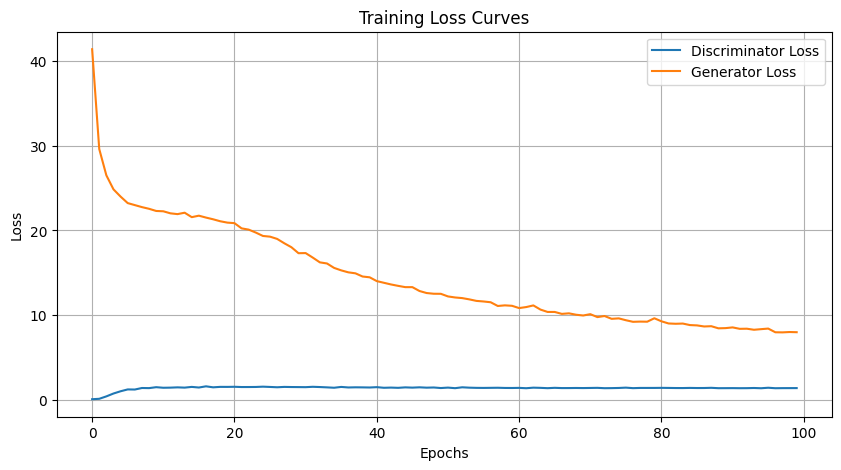

In [30]:
plot_loss_curves(loss_D_list, loss_G_list)

## Observations
As we can see from the graph, the both losses are coming down steadily, and there are no sudden spikes, which means the model is doing well. But I believe 100 epochs is still not enough. The discriminator seems to have plataued, but the generator hasnt plateaued yet, which would
suggest that the model is still learning.

More epochs will give the model enough time to learn. But lets test this out with some test data and check it out.

In [31]:
from torchsummary import summary

### Summary

Here is the summary of the final model.

In [32]:
summary(final_generator, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
         LeakyReLU-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]         524,544
       BatchNorm2d-6          [-1, 256, 32, 32]             512
         LeakyReLU-7          [-1, 256, 32, 32]               0
            Conv2d-8          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-9          [-1, 512, 16, 16]           1,024
        LeakyReLU-10          [-1, 512, 16, 16]               0
           Conv2d-11            [-1, 512, 8, 8]       4,194,816
      BatchNorm2d-12            [-1, 512, 8, 8]           1,024
        LeakyReLU-13            [-1, 512, 8, 8]               0
  ConvTranspose2d-14          [-1, 512,

# Evaluation

Now, we are going to evaluate our final model, using a different subset of the original data from kaggle.

Remember, we only used the first 100 paired images to train the models. So, now we are going to use 10 images from the dataset from the 1001st to 1010th image, to evaluate this model.

In [33]:
def visualize_images(face_image, generated_comic):
   
    face_image = face_image / 2 + 0.5  
    generated_comic = generated_comic / 2 + 0.5  

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].imshow(face_image.permute(1, 2, 0).cpu().numpy())
    ax[0].set_title('Input Face Image')
    ax[0].axis('off')

    ax[1].imshow(generated_comic.squeeze(0).permute(1, 2, 0).cpu().numpy())
    ax[1].set_title('Generated Comic Image')
    ax[1].axis('off')
    
    plt.show()

In [34]:
final_dataset_fn, final_dataset_len = get_dataset('/Users/cuibin/Desktop/archive/face2comics', image_size=256)

subset_indices = list(range(1000, 1010))  

final_dataloader = get_dataloader_from_fn(final_dataset_fn, final_dataset_len, batch_size=4, shuffle=True, num_workers=0, subset_indices=subset_indices)

for batch in final_dataloader:
    print(batch['face'].shape, batch['comic'].shape)
    break

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


Generated comic shape: torch.Size([4, 3, 256, 256])
Shape after selecting first image: torch.Size([3, 256, 256])


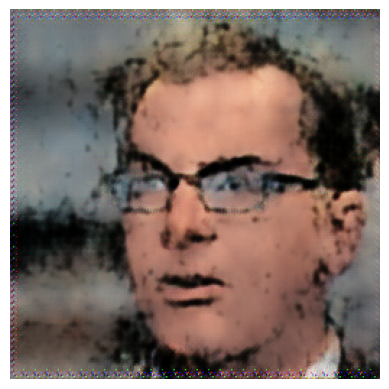

Generated comic shape: torch.Size([4, 3, 256, 256])
Shape after selecting first image: torch.Size([3, 256, 256])


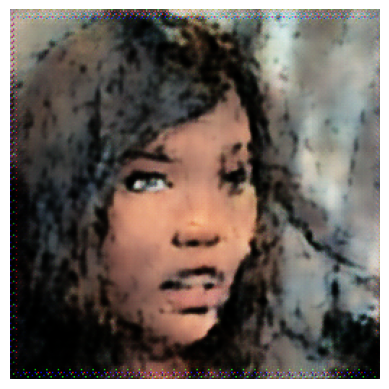

Generated comic shape: torch.Size([2, 3, 256, 256])
Shape after selecting first image: torch.Size([3, 256, 256])


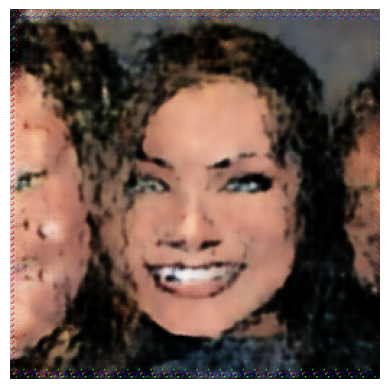

In [40]:
# Iterate over the subset of images from the dataloader
for batch in final_dataloader:
    real_face = batch['face'].to(device)
    real_comic = batch['comic'].to(device)

    # Generate comic images from real faces using the trained model
    with torch.no_grad():
        generated_comic = final_generator(real_face)

    # Check the shape of the generated comic image
    print(f"Generated comic shape: {generated_comic.shape}")  # Should be [batch_size, channels, height, width]

    # Select the first image from the batch for visualization (batch_size=4, so indexing with [0])
    generated_comic = generated_comic[0].cpu().detach()  # Select first image, remove batch dimension

    # Check the shape after removing the batch dimension
    print(f"Shape after selecting first image: {generated_comic.shape}")  # [channels, height, width]

    # Convert tensor to NumPy array and transpose to the correct shape for visualization
    generated_comic = generated_comic.permute(1, 2, 0).numpy()  # Change from [channels, height, width] to [height, width, channels]

    # Rescale the image to [0, 1] range for visualization (since the model was trained on [-1, 1] range)
    generated_comic = (generated_comic + 1) / 2  # Rescale to [0, 1]

    # Display the generated comic image
    plt.imshow(generated_comic)
    plt.axis('off')  # Turn off axis
    plt.show()

As we can clearly see, the model is capable of generating comic resembling images from human images. But, as we saw earlier, we need to train the model more to generate more accurate images.

# Final Thoughts

This was a really fun project. I really wanted to try this out, ever since I worked on the CycleGAN Monet assignment. I was really facinated by what GANs can do, and I learnt a lot from this project.

From the looks of it, it does appear that the U-Net model, when tuning hyperparameters, was over-fitting. But, it was the best model to use for this particular dataset.

I wanted to use ResNet for this, as I believe that would have generated more accurate images, but due to the time and device restrictions, I could not work with that this time.

# Things to improve on

1. I would like to try ResNet architecture for the generator
2. Try out more hyperparameters. Want to try out more values for the existing tests, and also try out more parameters in general like batch_
size etc.
3. During the hyperparameter tuning, would also like to try to train the models for more epochs (atleast a 100 epochs). And the final_model for atleast 200 epochs.
4. The GAN Loss and the L1 Loss failed to show overfitting. So, maybe we should try more or different metrics, like SSIM or PSNR.